# 50.039 Theory and Practice of Deep Learning - Small Project
This notebook contains all the code involved in the project. Code can be run in order to reproduce what was being done throughout the project.

## Setting up

(Special) Requirements:

* python >= 3.6
* torch >= 1.7

If on colab, run the following cells:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
!git clone https://github.com/LinHuiqing/50.039-TheoryAndPracticeOfDeepLearning-SmallProject.git

In [ ]:
cd /content/gdrive/MyDrive/50.039-TheoryAndPracticeOfDeepLearning-SmallProject

Otherwise, to set up requirements using `conda` do either of the following:

* In an existing environment, install all packages in `requirements.txt`:
    ```
    conda install --file requirements.txt
    ```
* Create an existing environment with either `requirements.txt` or `deeplearning_smallproj.yml`:
    ```
    # using requirements.txt
    conda create --name <env> --file requirements.txt

    # using deeplearning_smallproj.yml
    conda env create -f deeplearning_smallproj.yml
    ```

Import the relevant packages below.

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# tqdm
from tqdm.notebook import tqdm

## Dataset and Dataloader

In [2]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530,\
                                'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_noncovid': 8,\
                                'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_noncovid': 242}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid/',\
                              'val_normal': './dataset/val/normal/',\
                              'val_infected_covid': './dataset/val/infected/covid/',\
                              'val_infected_noncovid': './dataset/val/infected/non-covid/',\
                              'test_normal': './dataset/test/normal/',\
                              'test_infected_covid': './dataset/test/infected/covid/',\
                              'test_infected_noncovid': './dataset/test/infected/non-covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        

    def show_distribution(self):
        """
        Plotting function.
        Will plot the graphs showing the distribution of images among classes when called.
        """
        # Data to plot
        data = [list(self.dataset_numbers.values())[0:3], list(self.dataset_numbers.values())[3:6], list(self.dataset_numbers.values())[6:9]]
        labels = []
        for key, value in self.classes.items():
            labels.append("Class {}:\n{}".format(key, value))
        
        # Format plot area
        X = np.arange(len(labels))
        width = 0.15
        fig, ax = plt.subplots()
        rects1 = ax.bar(X - width, data[0], width , label = 'train')
        rects2 = ax.bar(X, data[1], width, label='validation')
        rects3 = ax.bar(X + width, data[2], width, label = 'test')
        fig.tight_layout()
        fig.set_size_inches(18.5, 10.5)

        # Add plot title, y-axis label, custom x-axis tick labels
        ax.set_ylabel('Number of images', fontsize = 17)
        ax.set_title('Number of images by dataset type and class', fontsize = 17)
        ax.set_xticks(X)
        ax.set_xticklabels(labels, Fontsize = 17)
        ax.legend(fontsize = 17)

        # Display plot
        plt.yticks(fontsize = 15)
        plt.show()

        # Save figure
        filename = 'Image_Distribution.png'
        fig.savefig(filename, dpi=100)
        print("Plot has been saved as {} in the submission folder.".format(filename))


    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

It can simply be called, and a generic description can be displayed.

This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5856 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 9 images.
 - val_infected_noncovid, in folder ./dataset/val/infected/non-covid/: 8 images.
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 139 images.
 - test_infected_noncovid, in folder ./dataset/test/infected/non

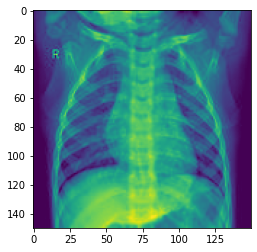

In [47]:
ld_general = Lung_Dataset()
ld_general.describe()
im = ld_general.open_img('train', 'normal', 1)
print(im.shape)
print(im)
ld_general.show_img('train', 'normal', 1)

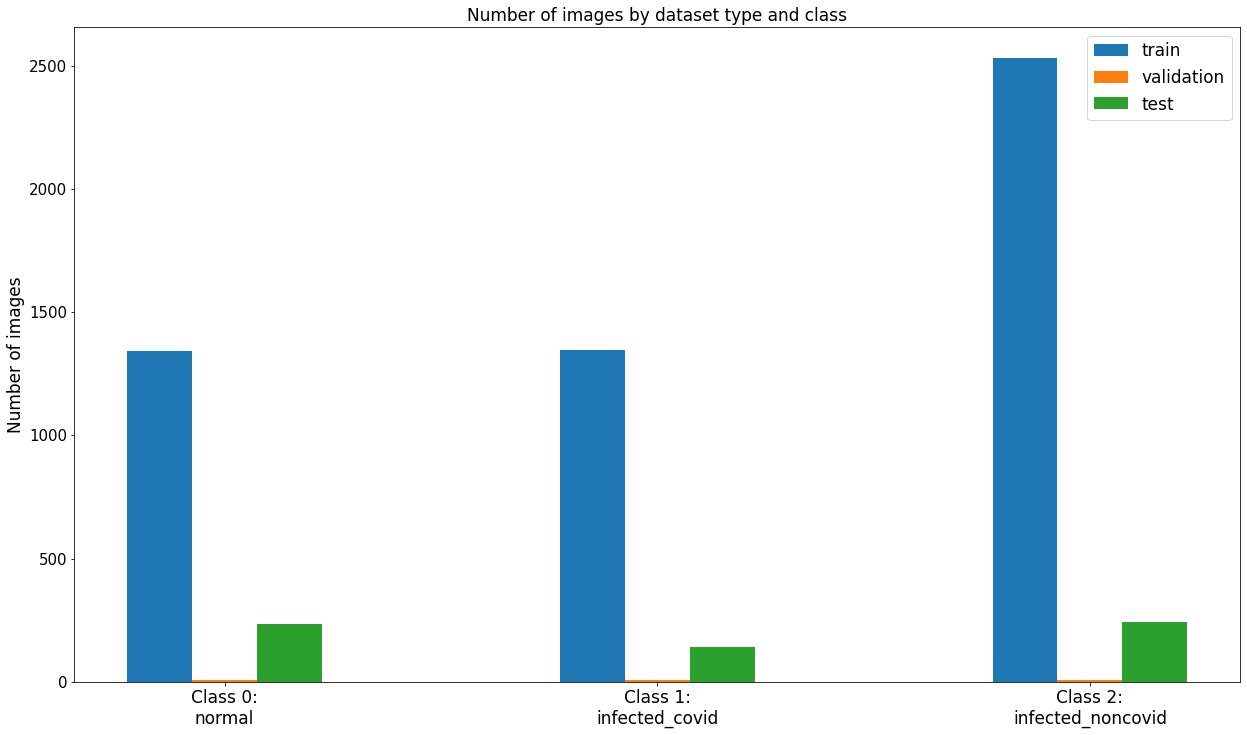

Plot has been saved as Image_Distribution.png in the submission folder.


In [48]:
ld_general.show_distribution()

2.b. Creating a train Dataset object
In practice however, one likes to define several datasets, for each subgroup (train, test, validation). This class however, will only be used to load images from the ./dataset_demo/train/ folder. It woks roughly as the previous Lung_Dataset class. In practice, we could have inherited Lung_Train_Dataset from Lung_Dataset, but we normally do not bother creating a general Dataset object like Lung_Dataset in Section 2.a.
The Lung_Train_Dataset object resembles to the Lung_Dataset as it contains restricted versions of the same attributes we had in the Lung_Dataset object.
It however contains two additional (special) methods, which need to be defined if we want to transform our Lung_Train_Dataset object into a dataloader later on.
The first method is the special length method ( len ), which should return the number of images present in the dataset. Lucky for us, it can be easily computed using the dataset_numbers attribute of our object.
The second one is the special getitem method ( getitem ), which is used to fetch an image and its label, using a single index value.
By convention here, we have decided to open the image in ./dataset_demo/train/normal/XXX.jpg, if the value in XXX is strictly lower than 36, which is the number of images in the ./dataset_demo/train/normal/ folder.
Otherwise, we open the image in ./dataset_demo/train/infected/YYY.jpg, where YYY is simply defined as YYY = XXX - 36.
Note that if the value in XXX is larger than the length of the dataset, i.e. 36 + 34 = 70, then no image will be opened and the getitem will display an error, based on the asserts we have in the open_img method.
Finally, the getitem method will return the image, along with a one-hot vector corresponding to the class of the object, i.e. [1, 0] for normal class and [0, 1] for infected class. Both returned parameters will be torch tensors.

In [5]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self, transformations_list, normalize = None, class_type = 'augmented'):
        """
        Constructor for the Training Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected_covid, and infected_noncovid)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the original dataset
        self.og_dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530}

        # Number of images in each part of the extended dataset
        self.extended_dataset_numbers = {'train_normal': 2682,\
                                'train_infected_covid': 2690,\
                                'train_infected_noncovid': 5060}
        
        # Path to images for different parts of the original dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid/'}

        self.transform = transforms.Compose(transformations_list)   

        self.normalize = normalize  

        self.class_type = class_type                                      
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the extended training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "Data augmentation was performed to extended the training dataset. Each image was transformed once to produce a new image of size {} by {}, ". format(self.img_size[0], self.img_size[1])
        msg += "hence the\nextended dataset contains a total of {} images, which is twice the number in the original dataset. ".format(sum(self.extended_dataset_numbers.values()))
        msg += "Please note that data augmentation is only\nperformed when the dataset is loaded to retrieve the transformed images. "
        msg += "The augmented data are not saved to files."
        msg += "Otherwise, the images of the original\ndataset (before data augmentation) are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.og_dataset_numbers[key])
        print(msg)

    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.og_dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im

    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in the original dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

           
    def __len__(self):
        """
        Length special method, returns the number of images in the extended dataset.
        """
        
        if self.class_type == 'augmented':
            return sum(self.extended_dataset_numbers.values())
        elif self.class_type == 'infected':
            return self.extended_dataset_numbers['train_infected_covid']+ self.extended_dataset_numbers['train_infected_noncovid']
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/train/infected/covid/YYY.jpg if XXX is strictly lower than 1345 (number of images in class 1: infected_covid) and
        - transform the image in ./dataset/train/infected/covid/YYY.jpg if XXX is between 1345 (inclusive) and 2690 (exclusive) (twice the number of images
          in the ./dataset/train/infected/covid/ folder), where YYY = XXX - 1345.
        - open the image in ./dataset/train/infected/non-covid/ folder if XXX is between 2690 (inclusive) and  5220 (exclusive) (5220 - 2690 = 2530 number
          of images in the ./dataset/train/infected/non-covid/ folder), where YYY = XXX - 2690.
        - transform the image in ./dataset/train/infected/non-covid/YYY.jpg if XXX is between 5220 (inclusive) and 7750 (exclusive) (total number of images
          in classes 1 and 2 after augmentation), where YYY = XXX - 5220.
        - open the image in ./dataset/train/normal/YYY.jpg if XXX is between 7750 (inclusive) and 9091 (exclusive) (7750 + number of images in the
          ./dataset/train/normal/ folder), where YYY = XXX - 7750
        - transform the image in ./dataset/train/normal/YYY.jpg if XXX is between 9091 (inclusive) and 10432 (exclusive) (twice the number of
          images in all classes), where YYY = XXX - 9091.

        
        Returns the image and its label as a one hot vector, both in torch tensor format in dataset.
        """

        # Get item special method
        first_val = int(list(self.og_dataset_numbers.values())[0]) # number of images in class 0: normal = 1341
        second_val = int(list(self.og_dataset_numbers.values())[1]) # number of images in class 1: infected_covid = 1345
        third_val = int(list(self.og_dataset_numbers.values())[2]) # number of images in class 2: infected_noncovid = 2530
        if index < second_val*2: # not inclusive because image labelling starts from 0, not 1
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])
            if index < second_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index-second_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)

        elif (second_val*2) <= index < (second_val + third_val)*2:
            index -= second_val*2
            class_val = 'infected_noncovid'
            label = torch.Tensor([0, 0, 1])
            if index < third_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index - third_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)

        else:
            index -= (second_val + third_val) *2
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
            if index < first_val:
                im = self.open_img(self.groups, class_val, index)
                im = transforms.functional.to_tensor(im).float()
            else:
                adjusted_index = index - first_val
                im = self.open_img(self.groups, class_val, adjusted_index)
                im = transforms.functional.to_tensor(im).float()
                im = self.transform(im)
        
        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

We can then create our Dataset object as before and display a description of the dataset.

In [50]:
transformation_list = [transforms.RandomAffine(degrees = 15, translate = (5/150, 5/150), scale=(9/10, 11/10), shear=None),\
                       transforms.GaussianBlur(kernel_size = 3, sigma=(0.1, 2.0))]
ld_train = Lung_Train_Dataset(transformation_list) # extended dataset
ld_train.describe()
print(len(ld_train)) # gives total number of images in the extended train dataset
trainloader = DataLoader(ld_train, batch_size = 4, num_workers = 0, shuffle = True)

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
The original dataset (before data augmentation) contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.
Data augmentation was performed to extended the training dataset. Each image was transformed once to produce a new image, hence the total
number of images in the extended dataset is twice the number in the original dataset, i.e. 10432.
Please note that data augmentation is only performed and transformed images are only retrieved when the dataset is loaded. The augmented
data are not saved to files.
10432


In [51]:
ld_train_infected = Lung_Train_Dataset(transformation_list, class_type='infected')
print(len(ld_train_infected))
infected_train_loader = DataLoader(ld_train_infected, batch_size = 4, num_workers = 0, shuffle = True)


7750


Using the getitem method (i.e. using square bracket indexing on our object) will produce a 150 by 150 torch tensor corresponding to our image, with normalize values. It also produces a one-hot vector, in torch tensor format as well.

In [52]:
im, class_oh = ld_train[1360] # index = 1360 > 1341 so look at elif statement: 1360 - 1341 = 19 (label of image in infected_covid class)
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([0., 1., 0.])


2.c. Creating a test and val Dataset object
Following the same logic in Section 2.b., we can create a Lung_Test_Dataset and a Lung_Val_Dataset object. They operate in the exact same manner as the Lung_Train_Dataset object from Section 2.b., but working on a different subfolder.

In [53]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self, normalize = None, class_type = 'original'):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected_covid, and infected_noncovid)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_noncovid':242 }
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected_covid': './dataset/test/infected/covid',\
                              'test_infected_noncovid': './dataset/test/infected/non-covid'}
        
        self.normalize = normalize

        self.class_type = class_type
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'test'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_covid, or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        if self.class_type == 'original':
            return sum(self.dataset_numbers.values())
        elif self.class_type == 'infected':
            return self.dataset_numbers['test_infected_covid']+ self.dataset_numbers['test_infected_noncovid']
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/test/infected/covid/XXX.jpg if XXX is strictly lower 139
        - open the image in ./dataset/test/infected/non-covid/YYY.jpg if XXX is between 139 and 381, where YYY = XXX-139.
        - otherwise, the image in ./dataset/test/normal/YYY.jpg if XXX is between 381 (inclusive) and 615 (exclusive), where YYY = XXX - 381.

        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
         # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0]) # number of images in class 0: normal = 234
        second_val = int(list(self.dataset_numbers.values())[1]) # number of images in class 1: infected_covid = 139
        third_val = int(list(self.dataset_numbers.values())[2]) # number of images in class 2: infected_noncovid = 242
        if index < second_val: # not inclusive because image labelling starts from 0, not 1
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])

        elif second_val <= index < (second_val + third_val):
            index -= second_val
            class_val = 'infected_noncovid'
            label = torch.Tensor([0, 0, 1])

        else:
            index -= (second_val + third_val)
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(im).float()

        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

In [54]:
ld_test = Lung_Test_Dataset()
ld_test.describe()
testloader = DataLoader(ld_test, batch_size = 4, num_workers = 0, shuffle = True)

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 615 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid: 139 images.
 - test_infected_noncovid, in folder ./dataset/test/infected/non-covid: 242 images.



In [11]:
ld_test_infected = Lung_Test_Dataset(class_type = 'infected')
print(len(ld_test_infected))
infected_test_loader = DataLoader(ld_test_infected, batch_size = 4, num_workers = 0, shuffle = True)

381


In [55]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self, normalize = None, class_type = 'original'):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected_covid, and infected_noncovid)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of validation images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_noncovid': 8 }
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                              'val_infected_covid': './dataset/val/infected/covid',\
                              'val_infected_noncovid': './dataset/val/infected/non-covid'}
        
        self.normalize = normalize

        self.class_type = class_type


    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the validation dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        if self.class_type == 'original':
            return sum(self.dataset_numbers.values())
        
        elif self.class_type == 'infected':
            return self.dataset_numbers['val_infected_covid']+ self.dataset_numbers['val_infected_noncovid']
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Convention:
        - open the image in ./dataset/val/infected/covid/XXX.jpg if XXX is strictly lower than 9
        - open the image in ./dataset/val/infected/non-covid/YYY.jpg if XXX is between 9 (inclusive) and 17 (exclusive)
          where YYY = XXX - 8.
        - otherwise, open the image in ./dataset/val/normal/ folder 

        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0]) # number of images in class 0: normal = 8
        second_val = int(list(self.dataset_numbers.values())[1]) # number of images in class 1: infected_covid = 9
        third_val = int(list(self.dataset_numbers.values())[2]) # number of images in class 2: infected_noncovid = 8
        if index < second_val: # not inclusive because image labelling starts from 0, not 1
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])

        elif second_val <= index < (second_val + third_val):
            index -= second_val
            class_val = 'infected_noncovid'
            label = torch.Tensor([0, 0, 1])

        else:
            index -= (second_val + third_val)
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(im).float()
        
        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

In [56]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the validation dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 25 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid: 9 images.
 - val_infected_noncovid, in folder ./dataset/val/infected/non-covid: 8 images.



In [57]:
ld_val_infected = Lung_Val_Dataset(class_type = 'infected')
print(len(ld_val_infected))
infected_val_loader = DataLoader(ld_val_infected, batch_size = 4, num_workers = 0, shuffle = True)

17


3. Creating a Dataloader object
The final step is to create Dataloaders, based on our previous Dataset objects. These Dataloaders will later be used for training, testing and evaluating our models in PyTorch.
The dataloaders can be simply created by using the DataLoader object from the torch.utils.data library, and by simply passing it our Dataset object. Additional parameters such as the batch_size (set to 4 for demo here) can be specified. Another interesting parameter is the shuffle = True one, which will randomly shuffle the order in which the images are selected in the Dataset.
Additional parameters for the DataLoader can be specified (see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for details), but it will not be necessary for this small project.

In [58]:
# NORMALISATION
def get_mean(data_loader, num_of_pixels):
    total_sum = 0
    for batch in tqdm(data_loader):
        total_sum += batch[0].sum()
    mean = total_sum/num_of_pixels
    return mean


def get_standard_deviation(data_loader, num_of_pixels, mean):
    sum_of_squared_error = 0
    for batch in tqdm(data_loader):
        sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
    std = torch.sqrt(sum_of_squared_error/num_of_pixels)
    return std

In [59]:
# Batch size value to be used
bs_val = 32

# Dataloader from train dataset
train_loader = DataLoader(ld_train, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
train_mean = get_mean(train_loader, num_of_pixels)
train_std = get_standard_deviation(train_loader, num_of_pixels, train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(train_mean, train_std))




The mean of the extended training dataset before normalisation is 0.4698736071586609.
The standard deviation of the extended training dataset before normalisation is 0.24454912543296814.


In [60]:
# Instantiating a new training dataset to be normalized before training
ld_train_normalized = Lung_Train_Dataset(transformation_list, (train_mean, train_std))

# Dataloader from normalized train dataset 
normalized_train_loader = DataLoader(ld_train_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
norm_train_mean = get_mean(normalized_train_loader, num_of_pixels)
norm_train_std = get_standard_deviation(normalized_train_loader, num_of_pixels, norm_train_mean)
print("The mean of the extended training dataset after normalisation is {}.\nThe standard deviation of the extended training dataset after normalisation is {}.".format(norm_train_mean, norm_train_std))



The mean of the extended training dataset after normalisation is 0.002884338144212961.
The standard deviation of the extended training dataset after normalisation is 0.9988458752632141.


In [61]:
# Instantiating a new test dataset to be normalized before testing
ld_test_normalized = Lung_Test_Dataset((train_mean, train_std))

# Dataloader from normalized test dataset 
normalized_test_loader = DataLoader(ld_test_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
norm_test_mean = get_mean(normalized_test_loader, num_of_pixels)
norm_test_std = get_standard_deviation(normalized_test_loader, num_of_pixels, norm_test_mean)
print("The mean of the test dataset after normalisation is {}.\nThe standard deviation of the test dataset after normalisation is {}.".format(norm_test_mean, norm_test_std))



The mean of the test dataset after normalisation is 0.0010512401349842548.
The standard deviation of the test dataset after normalisation is 0.23407715559005737.


In [62]:
# Instantiating a new validation dataset to be normalized before testing
ld_val_normalized = Lung_Val_Dataset((train_mean, train_std))

# Dataloader from validation test dataset 
normalized_val_loader = DataLoader(ld_val_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
norm_val_mean = get_mean(normalized_val_loader, num_of_pixels)
norm_val_std = get_standard_deviation(normalized_val_loader, num_of_pixels, norm_val_mean)
print("The mean of the validation dataset after normalisation is {}.\nThe standard deviation of the validation dataset after normalisation is {}.".format(norm_val_mean, norm_val_std))


The mean of the validation dataset after normalisation is 0.000277051207376644.
The standard deviation of the validation dataset after normalisation is 0.051589030772447586.


During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.
Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.
We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [63]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[7.6078e-01, 7.1373e-01, 6.6667e-01,  ..., 7.8431e-03,
           0.0000e+00, 0.0000e+00],
          [7.3333e-01, 7.0588e-01, 6.6667e-01,  ..., 0.0000e+00,
           0.0000e+00, 3.9216e-03],
          [7.1373e-01, 7.0980e-01, 6.7451e-01,  ..., 0.0000e+00,
           0.0000e+00, 7.8431e-03],
          ...,
          [9.0196e-02, 8.2353e-02, 7.4510e-02,  ..., 9.8039e-02,
           1.0588e-01, 1.1373e-01],
          [9.0196e-02, 8.2353e-02, 7.4510e-02,  ..., 7.8431e-02,
           8.2353e-02, 8.6275e-02],
          [9.0196e-02, 8.2353e-02, 7.4510e-02,  ..., 7.8431e-02,
           7.8431e-02, 7.8431e-02]]],


        [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  .

4. Using our dataloader for training a model
We can then use our custom dataloader for training a model. If we decide to create a model as a subclass of the nn.Module of PyTorch, and later write a train function, as in this Notebook shown in class (https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8), then our train_loader object defined in Section 3., can be directly fed to our train function in place of the train_loader.
We could for instance, define a simple (probably too simple!) model below.


## Defining Model Architecture
In deep learning, as there are many parameters which are empirically derived and not deduced from mathematical formulae. As such, we first experiment with some parameters before finding the optimal parameters for our final model. The parameter we will be looking at specifically will be the number of layers as this seems to be much more vague than the other model parameters.

### Process
Based on our research described in the report, we will first try 8 models for each classifier, with each model having one more convolution layer than the previous one.

### Testing of No. of Layers for Binary Classifier 1 (infected classifier - normal vs infected)

The model class for the experiment is first defined below:

In [64]:
from typing import OrderedDict


class ConvNetV1(nn.Module):
    def __init__(self, 
                 no_of_layers: int) -> None:
        super(ConvNetV1, self).__init__()
        output_channels = [64, 64, 64, 128, 128, 256, 256, 512, 512]

        if no_of_layers > len(output_channels)-1:
            raise ValueError(f"no_of_layers must be less than {len(output_channels)-1}")

        self.conv0 = nn.Conv2d(1, output_channels[0], 7, stride=2)
        self.maxpool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        if no_of_layers > 0:
            layers = OrderedDict()
            for i in range(no_of_layers):
                layers[f"{i+1}"] = nn.Conv2d(output_channels[i], output_channels[i+1], 3)
            self.layers = nn.Sequential(layers)
        
        self.fc = nn.Linear(output_channels[no_of_layers], 2)
        print(self)

    def forward(self, x):
        x = self.conv0(x)
        x = self.maxpool0(x)
        x = self.layers(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim = 1)
        return output

To allow the model to train until its overfit, the `EarlyStopping` is defined as follows. This class keeps track of the number of epochs run where the test loss has not improved, and this is a sign that the model has overfit to the train set.

In [65]:
class EarlyStopping:
    def __init__(self, 
                 patience:int=10, 
                 delta:int=0) -> None:
        self.patience = patience
        self.delta = delta

        self.best_score = float("inf")
        self.overfit_count = 0

    def stop(self, test_loss):
        threshold = self.best_score + self.delta
        if test_loss > threshold:
            self.overfit_count += 1
            print(f"Increment early stopper to {self.overfit_count} because test loss ({test_loss}) is greater than threshold ({threshold})")
        else:
            self.overfit_count = 0
        
        self.best_score = min(self.best_score, test_loss)
        
        if self.overfit_count >= self.patience:
            return True
        else:
            return False

Next, some helper functions are defined. These functions make the the code easier to read and are used at multiple points of this project.

In [175]:
def extract_labels(labels_all:torch.tensor, 
                   pos_label: torch.tensor, 
                   device:str):
    t_one = torch.ones(1).to(device)
    t_zero = torch.zeros(1).to(device)
    if pos_label == "infected":
        flipped_labels = labels_all[:, 0].to(device)
        labels = torch.where(flipped_labels == 0, t_one, t_zero)
        return torch.stack([flipped_labels, labels], dim=1)
    elif pos_label == "covid":
        labels = labels_all[:, 1].to(device)
        flipped_labels = torch.where(labels == 0, t_one, t_zero)
        return torch.stack([flipped_labels, labels], dim=1)
    else:
        raise ValueError(f"{pos_label} is not a valid positive label")

def get_confusion_matrix(labels: torch.tensor, 
                         preds: torch.tensor, 
                         class_idx: int =-1):
    labels, preds = labels[:, class_idx], preds[:, class_idx]
    true_pred = torch.where(labels == preds, True, False)
    pos_pred = torch.where(preds == 1, True, False)
    neg_pred = ~pos_pred

    true_n_pos_stack = torch.stack([true_pred, pos_pred], dim=1)
    true_n_neg_stack = torch.stack([true_pred, neg_pred], dim=1)

    true_positive = torch.all(true_n_pos_stack, dim=1)
    false_negative = torch.all(true_n_pos_stack==False, dim=1)
    true_negative = torch.all(true_n_neg_stack, dim=1)
    false_positive = torch.all(true_n_neg_stack==False, dim=1)

    return true_positive, true_negative, false_positive, false_negative

def get_metrics(true_pos, true_neg, false_pos, false_neg):
    accuracy = float((true_pos.sum() + true_neg.sum()) / len(true_pos))
    precision = float(true_pos.sum() / (true_pos.sum() + false_pos.sum()))
    recall = float(true_pos.sum() / (true_pos.sum() + false_neg.sum()))
    try:
        f1_score = float((2 * recall * precision) / (recall + precision))
    except ZeroDivisionError:
        f1_score = 0

    return accuracy, precision, recall, f1_score

A loader function is defined below as well to load past models.

In [67]:
def load_model(model: nn.Module, 
               filepath: str) -> nn.Module:
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model

Define the `train` function to train the model, along with the `test` function to check how the model performs on data that is not in the train set.

In [156]:
import time
import os

# define test function 
def test(model: nn.Module, 
         test_loader: DataLoader, 
         criterion, 
         device: str, 
         pos_label: str) -> (float, float, float, float):
    test_loss = 0
    acc_store = preci_store = recall_store = f1_store = 0
    
    for images, labels in test_loader:
        labels = extract_labels(labels, pos_label, device)
        images, labels = images.to(device), labels.to(device)
        
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        # output = torch.exp(output)
        output = output.argmax(1)
        output = F.one_hot(output, num_classes=2)
        true_pos, true_neg, false_pos, false_neg = get_confusion_matrix(labels, output)
        accuracy, precision, recall, f1 = get_metrics(true_pos, true_neg, false_pos, false_neg)
        acc_store += accuracy
        preci_store += precision
        recall_store += recall
        f1_store += f1

    test_loss /= len(test_loader)
    acc_store /= len(test_loader)
    preci_store /= len(test_loader)
    recall_store /= len(test_loader)
    f1_store /= len(test_loader)

    return test_loss, acc_store, preci_store, recall_store, f1_store

# define train function
def train(model: nn.Module, 
          train_loader: DataLoader, 
          test_loader: DataLoader, 
          no_of_epochs: int, 
          pos_label: str, 
          weight: torch.tensor, 
          pos_weight: torch.tensor, 
          save_dir:str=None, 
          patience:int=10, 
          device:str="cuda", 
          lr_scheduler:bool=False) -> (list, list, list, list, list, list):
    model.to(device)

    if save_dir != None:
        os.mkdir(save_dir)

    criterion = nn.BCEWithLogitsLoss(weight= weight, pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience//3, verbose=True)

    criterion.to(device)

    running_loss = 0

    train_loss_store, test_loss_store = [], []
    acc_store, preci_store, recall_store, f1_store = [], [], [], []
    early_stopper = EarlyStopping(patience=patience)

    start = time.time()
    for epoch in range(1, no_of_epochs+1):
        # train mode for training
        model.train()
        for images, labels in train_loader:
            labels = extract_labels(labels, pos_label, device)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # eval mode for predictions
        model.eval()

        # turn off gradients for test
        with torch.no_grad():
            test_loss, accuracy, precision, recall, f1 = test(model, test_loader, criterion, device, pos_label)

        train_loss_store.append(running_loss/len(train_loader))
        test_loss_store.append(test_loss)
        acc_store.append(accuracy)
        preci_store.append(precision)
        recall_store.append(recall)
        f1_store.append(f1)

        print(f"Epoch: {epoch}/{no_of_epochs} - ",
              f"Training Loss: {train_loss_store[-1]:.3f} - ",
              f"Test Loss: {test_loss_store[-1]:.3f} - ",
              f"Test Accuracy: {acc_store[-1]:.3f} - ", 
              f"Test Precision: {preci_store[-1]:.3f} - ", 
              f"Test Recall: {recall_store[-1]:.3f} - ", 
              f"Test F1 Score: {f1_store[-1]:.3f}")

        if save_dir != None:
            torch.save(model.state_dict(), f"{save_dir}/{epoch}.pt")
        
        if early_stopper.stop(test_loss_store[-1]):
            print("Model has overfit, early stopping...")
            break

        if lr_scheduler:
            scheduler.step(test_loss_store[-1])
        
        running_loss = 0

    print(f"Run time: {(time.time() - start)/60:.3f} min")
    
    return train_loss_store, test_loss_store, acc_store, preci_store, recall_store, f1_store


Call the train function to train the model. In this set up, we use the same dataloaders for the train and test data, while using a loop to increment the number of layers to test out new models.

In [75]:
# initialise variables to be used as arguments in train function
epochs = 1000 # set an arbitrarily high number of epochs
weight = torch.tensor([1, 1/3]) # weight to take into account the class imbalance in dataset
pos_weight = torch.tensor([1, 1.1]) # positive weight set to favour classification of infected

stats_store = {
    "train_loss": {},
    "test_loss": {},
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1": {},
}

# loop to train models with 1-8 layers
for i in range(8):
    train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV1(i+1), normalized_train_loader, normalized_test_loader, epochs, "infected", weight, pos_weight, save_dir=f"saved_models/ConvNetV1Infected_{i+1}")
    stats_store["train_loss"][f"ConvNetV1_{i+1}"] = train_loss
    stats_store["test_loss"][f"ConvNetV1_{i+1}"] = test_loss
    stats_store["accuracy"][f"ConvNetV1_{i+1}"] = accuracy
    stats_store["precision"][f"ConvNetV1_{i+1}"] = precision
    stats_store["recall"][f"ConvNetV1_{i+1}"] = recall
    stats_store["f1"][f"ConvNetV1_{i+1}"] = f1

ConvNetV1(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 1/1000 -  Training Loss: 0.339 -  Test Loss: 0.427 -  Test Accuracy: 0.738 -  Test Precision: 0.730 -  Test Recall: 0.926 -  Test F1 Score: 0.811
Epoch: 2/1000 -  Training Loss: 0.311 -  Test Loss: 0.403 -  Test Accuracy: 0.765 -  Test Precision: 0.779 -  Test Recall: 0.870 -  Test F1 Score: 0.818
Epoch: 3/1000 -  Training Loss: 0.309 -  Test Loss: 0.474 -  Test Accuracy: 0.724 -  Test Precision: 0.712 -  Test Recall: 0.922 -  Test F1 Score: 0.801
Increment early stopper to 1 because test loss (0.4735500827431679) is greater than threshold (0.4028038397431374)
Epoch: 4/1000 -  Training Loss: 0.305 -  Test Loss: 0.433 -  Test Accuracy: 0.730 -  Test Precision: 0.726 -  Test Reca

After training, we want to save the statistics from training, possibly for review later. This cell includes code to save or load statistics, depending on what the user needs. Uncomment accordingly.

In [202]:
import json 

store_file_name = "data_collected/ConvNetV1_infected_stats_store.json"

# # UNCOMMENT TO SAVE STATS
# with open(store_file_name, "w") as stat_store_file:
#     json.dump(stats_store, stat_store_file)

# UNCOMMENT TO LOAD STATS
with open(store_file_name) as stat_store_file:
    stats_store = json.load(stat_store_file)

Using the statistics we have gathered, plot graphs to help us determine the optimal number of convolution layers.

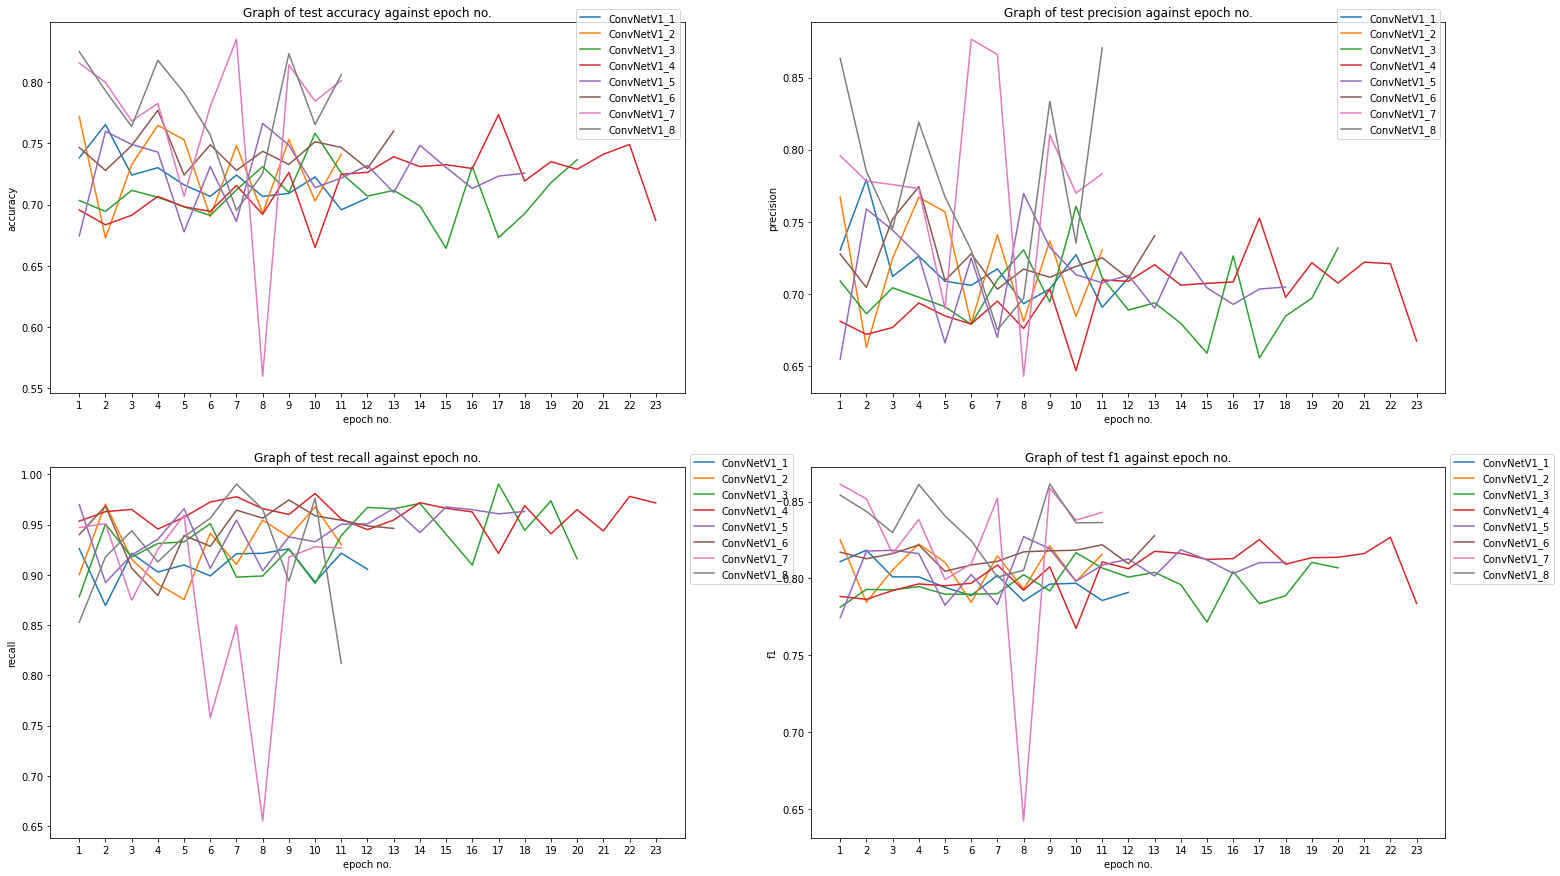

In [127]:
# plot graph of metrics against epochs for all models

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

# loop through all metrics to be plotted
for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    max_epochs = 0

    # loop through all models' statistics to be plotted
    for i in range(8):
        y_vals = stats_store[metric][f"ConvNetV1_{i+1}"]
        metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals, label = f"ConvNetV1_{i+1}")
        max_epochs = max(max_epochs, len(y_vals))

    metrics_ax_store[metric].set_xticks(list(range(1, max_epochs+1)))
    # show a legend on the plot
    metrics_ax_store[metric].legend(bbox_to_anchor=(1, 1.05))
    
plt.savefig('ConvNetV1_infected_metrics.png')
plt.show()

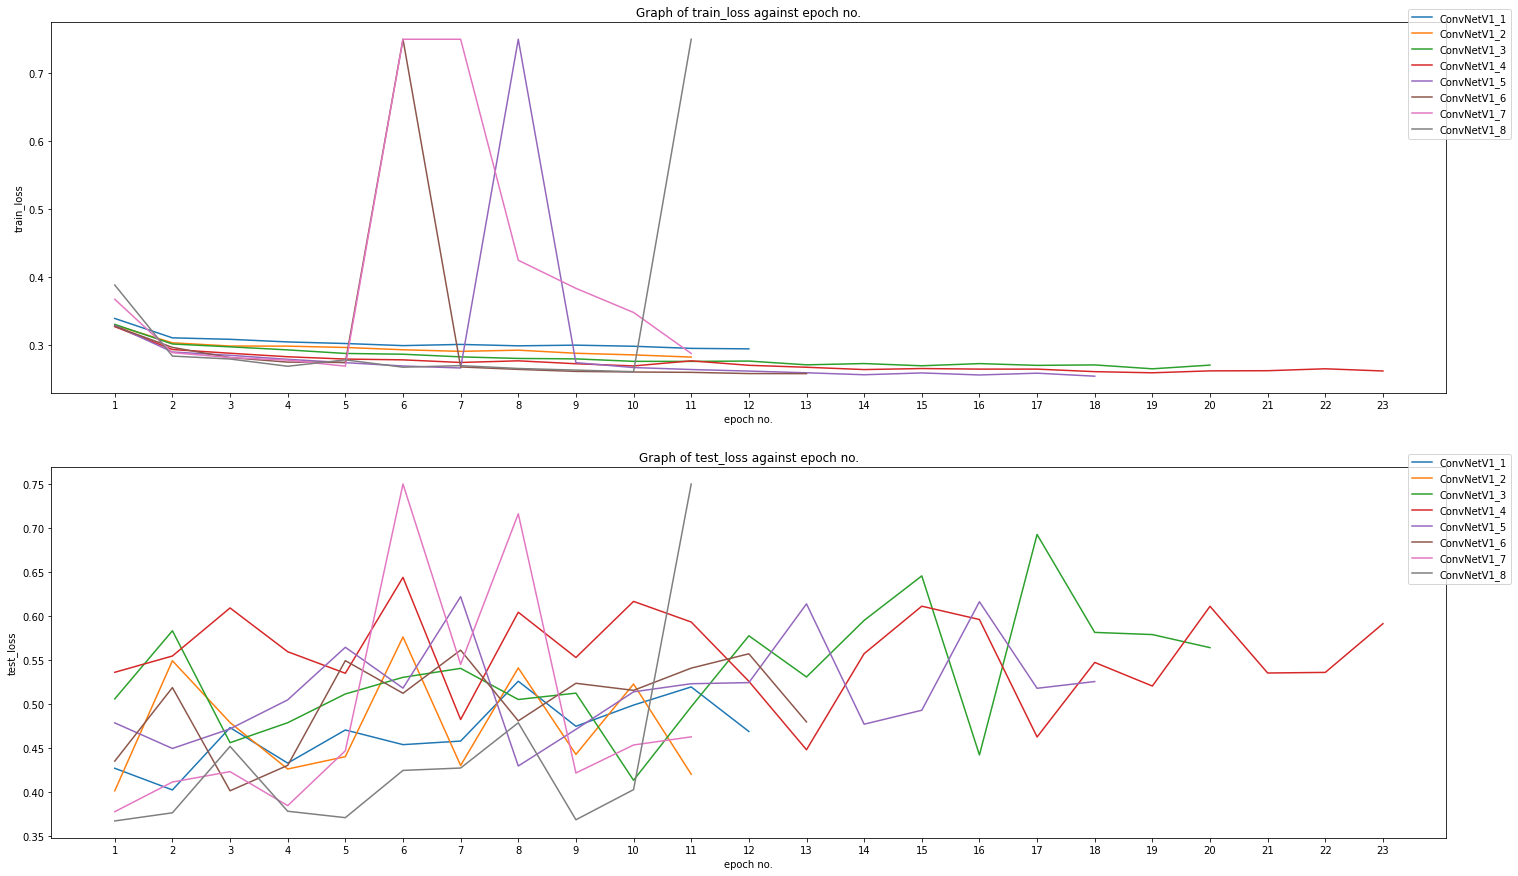

In [203]:
# plot graph of loss against epoch no.

losses = ["train_loss", "test_loss"]

loss_fig, (train_loss_ax, test_loss_ax) = plt.subplots(2, 1, figsize=(25,15))

loss_ax_store = {
    "train_loss": train_loss_ax,
    "test_loss": test_loss_ax,
}

for loss in losses:
    loss_ax_store[loss].title.set_text(f'Graph of {loss} against epoch no.')
    loss_ax_store[loss].set_ylabel(loss)
    loss_ax_store[loss].set_xlabel('epoch no.')

    max_epochs = 0

    for i in range(8):
        # clipping is done for the y values so as to better visualise the relative values for different models
        y_vals = np.array(stats_store[loss][f"ConvNetV1_{i+1}"])
        y_vals = np.clip(y_vals, a_min=0, a_max=0.75)

        # # uncomment for original y values
        # y_vals = stats_store[loss][f"ConvNetV1_{i+1}"]

        loss_ax_store[loss].plot(list(range(1, len(y_vals)+1)), y_vals, label = f"ConvNetV1_{i+1}")
        max_epochs = max(max_epochs, len(y_vals))

    loss_ax_store[loss].set_xticks(list(range(1, max_epochs+1)))
    loss_ax_store[loss].legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV1_infected_losses.png')
plt.show()

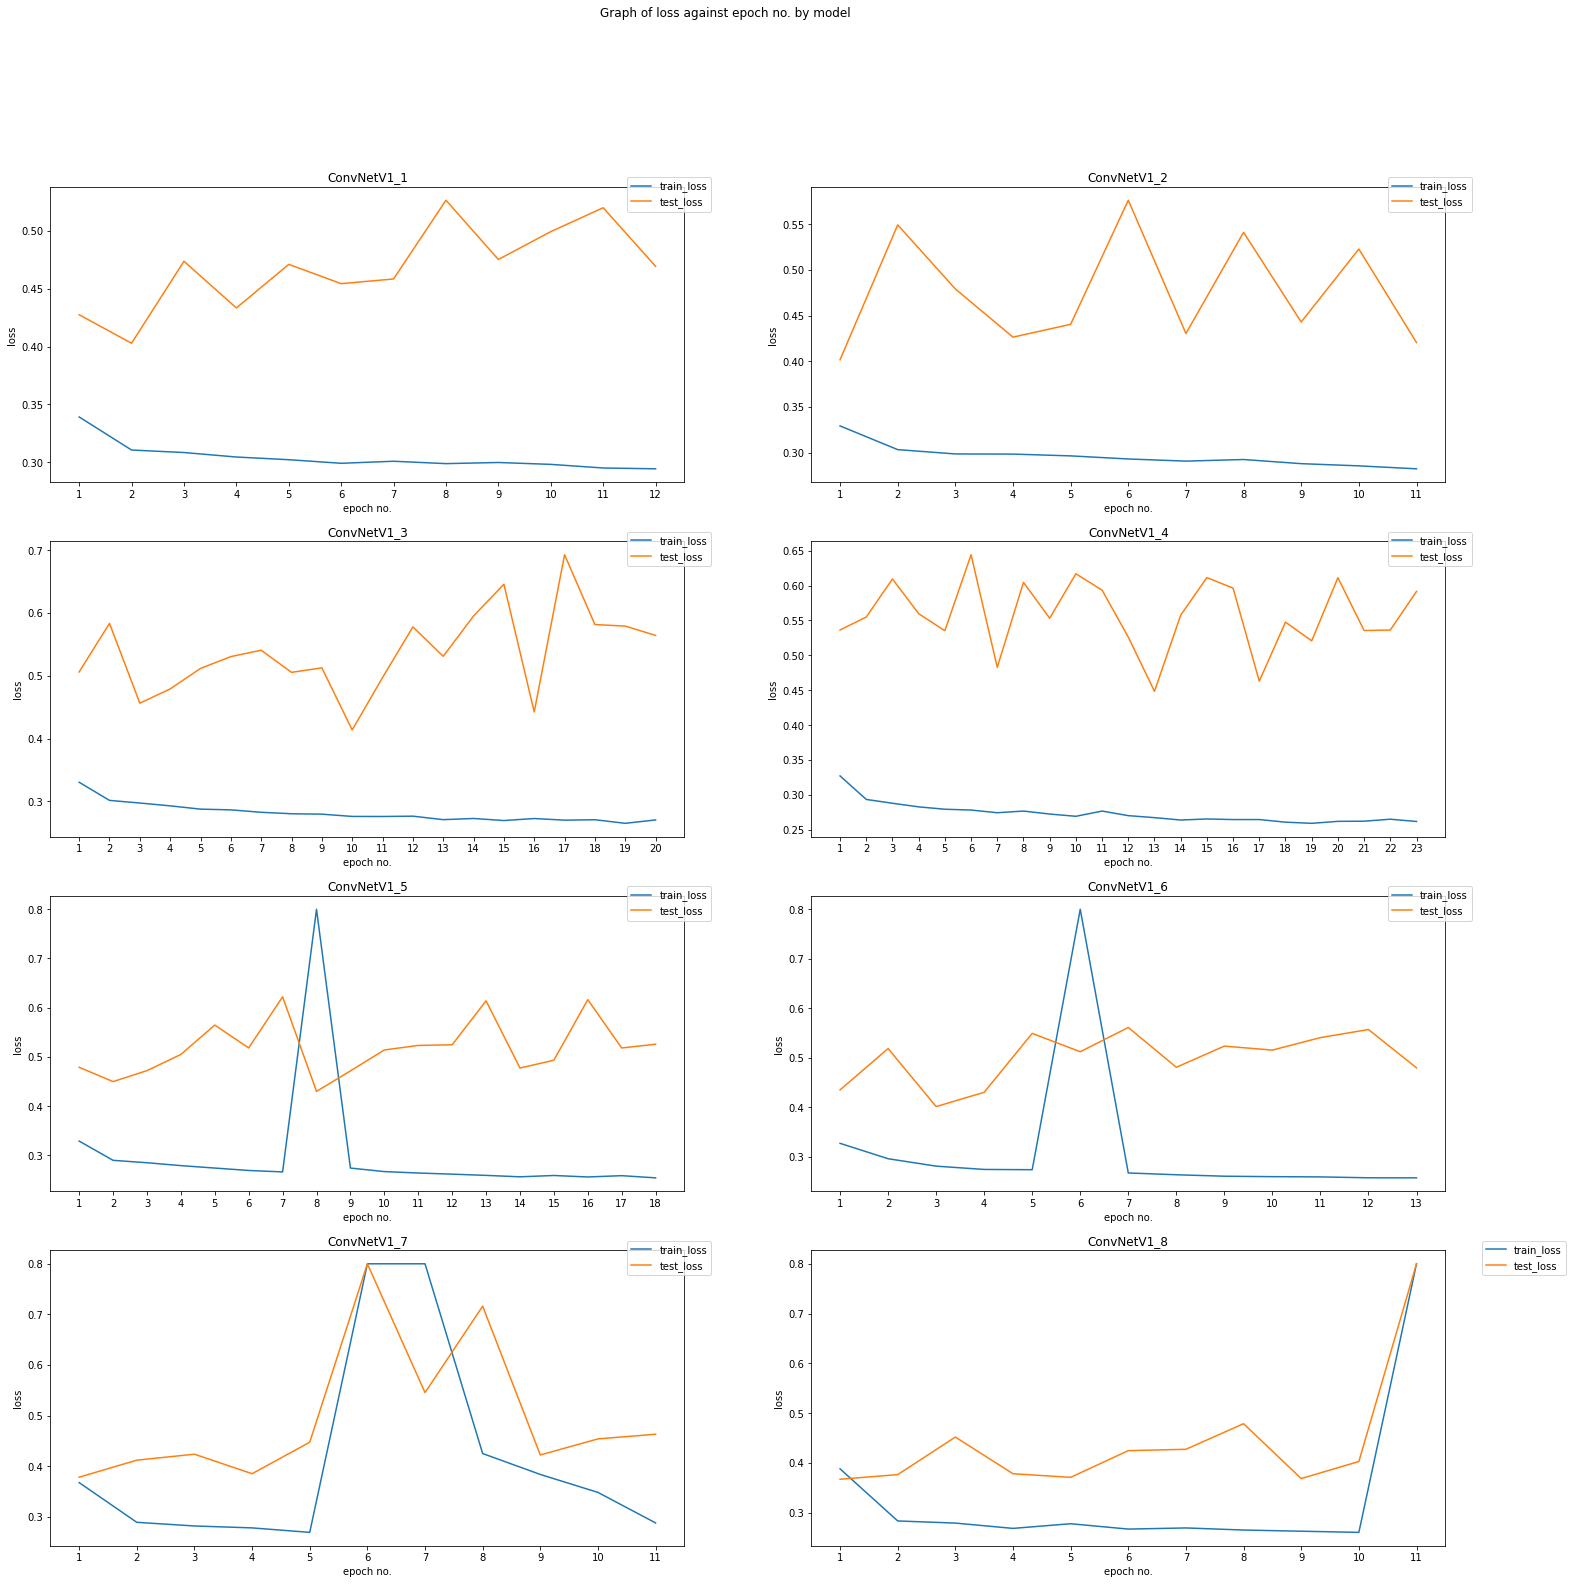

In [134]:
# plot graph of loss against epochs for each model for both train and test loss

losses = ["train_loss", "test_loss"]

loss_by_net_fig, loss_by_net_axs = plt.subplots(4, 2, figsize=(25, 25))
loss_by_net_fig.suptitle('Graph of loss against epoch no. by model')

for i in range(8):
    loss_by_net_axs[i//2, i%2].title.set_text(f'ConvNetV1_{i+1}')
    loss_by_net_axs[i//2, i%2].set_ylabel('loss')
    loss_by_net_axs[i//2, i%2].set_xlabel('epoch no.')

    max_epochs = 0

    for loss in losses:
        y_vals = np.array(stats_store[loss][f"ConvNetV1_{i+1}"])
        y_vals = np.clip(y_vals, a_min=0, a_max=0.8)
        # y_vals = stats_store[loss][f"ConvNetV1_{i+1}"]
        loss_by_net_axs[i//2, i%2].plot(list(range(1, len(y_vals)+1)), y_vals, label = loss)
        max_epochs = max(max_epochs, len(y_vals))

    loss_by_net_axs[i//2, i%2].set_xticks(list(range(1, max_epochs+1)))
    # show a legend on the plot
    loss_by_net_axs[i//2, i%2].legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV1_infected_losses_by_net.png')
plt.show()

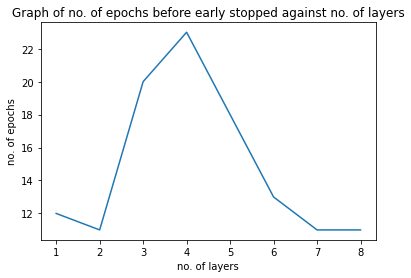

In [79]:
# plot graph of no.of epochs before model is stopped (overfit) against no. of layers in model

epochs_fig, epochs_ax = plt.subplots()
epochs_ax.title.set_text(f'Graph of no. of epochs before early stopped against no. of layers')
epochs_ax.set_ylabel('no. of epochs')
epochs_ax.set_xlabel('no. of layers')

y_vals = []

for i in range(8):
    epochs = len(stats_store["accuracy"][f"ConvNetV1_{i+1}"])
    y_vals.append(epochs)

epochs_ax.plot(list(range(1, 9)), y_vals)

plt.savefig('ConvNetV1_infected_epoch_layers.png')
plt.show()


### Testing of No. of Layers for Binary Classifier 2 (non-covid vs covid)

The same process mentioned above for Binary Classifier 1 is repeated for the second classifier below.

Load data for the second classifier. Only the infected samples should be extracted.

In [136]:
# Dataloader from infected train dataset
train_loader = DataLoader(ld_train_infected, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(ld_train_infected) * 150 * 150  # total number of pixels = number of images * image width * image height
train_mean = get_mean(train_loader, num_of_pixels)
train_std = get_standard_deviation(train_loader, num_of_pixels, train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(train_mean, train_std))


The mean of the extended training dataset before normalisation is 0.4715358316898346.
The standard deviation of the extended training dataset before normalisation is 0.24200816452503204.


In [137]:
# Instantiating a new infected training dataset to be normalized before training
ld_infected_train_normalized = Lung_Train_Dataset(transformation_list, (train_mean, train_std), class_type="infected")

# Dataloader from normalized train dataset 
infected_train_normalized_loader = DataLoader(ld_infected_train_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
infected_train_norm_mean = get_mean(infected_train_normalized_loader, num_of_pixels)
infected_train_norm_std = get_standard_deviation(infected_train_normalized_loader, num_of_pixels, infected_train_norm_mean)
print("The mean of the extended training dataset after normalisation is {}.\nThe standard deviation of the extended training dataset after normalisation is {}.".format(infected_train_norm_mean, infected_train_norm_std))


The mean of the extended training dataset after normalisation is -0.0013395380228757858.
The standard deviation of the extended training dataset after normalisation is 1.000443696975708.


In [138]:
# Instantiating a new infected test dataset to be normalized before testing
ld_infected_test_normalized = Lung_Test_Dataset((train_mean, train_std), class_type="infected")

# Dataloader from infected normalized test dataset 
infected_test_normalized_loader = DataLoader(ld_infected_test_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
infected_test_norm_mean = get_mean(infected_test_normalized_loader, num_of_pixels)
infected_test_norm_std = get_standard_deviation(infected_test_normalized_loader, num_of_pixels, infected_test_norm_mean)
print("The mean of the test dataset after normalisation is {}.\nThe standard deviation of the test dataset after normalisation is {}.".format(infected_test_norm_mean, infected_test_norm_std))



The mean of the test dataset after normalisation is -0.0010088513372465968.
The standard deviation of the test dataset after normalisation is 0.21076810359954834.


Use a for loop to train models with 1-8 layers.

In [140]:
# arguments for train function
epochs = 1000 # use an arbitrarily large number of epochs (as the model will be stopped before that)
weight = torch.tensor([1/2, 1]) # used to account for class imbalance in loss
pos_weight = torch.tensor([1, 1.1]) # used for model to favour positive cases

stats_store = {
    "train_loss": {},
    "test_loss": {},
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1": {},
}

# loop through numbers to train models with 1-8 layers
for i in range(8):
    train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV1(i+1), infected_train_normalized_loader, infected_test_normalized_loader, epochs, "covid", weight, pos_weight, save_dir=f"saved_models/ConvNetV1Covid_{i+1}")
    stats_store["train_loss"][f"ConvNetV1_{i+1}"] = train_loss
    stats_store["test_loss"][f"ConvNetV1_{i+1}"] = test_loss
    stats_store["accuracy"][f"ConvNetV1_{i+1}"] = accuracy
    stats_store["precision"][f"ConvNetV1_{i+1}"] = precision
    stats_store["recall"][f"ConvNetV1_{i+1}"] = recall
    stats_store["f1"][f"ConvNetV1_{i+1}"] = f1

ConvNetV1(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 1/1000 -  Training Loss: 0.548 -  Test Loss: 0.538 -  Test Accuracy: 0.675 -  Test Precision: nan -  Test Recall: 0.139 -  Test F1 Score: nan
Epoch: 2/1000 -  Training Loss: 0.546 -  Test Loss: 0.534 -  Test Accuracy: 0.712 -  Test Precision: 0.632 -  Test Recall: 0.405 -  Test F1 Score: 0.481
Epoch: 3/1000 -  Training Loss: 0.545 -  Test Loss: 0.545 -  Test Accuracy: 0.652 -  Test Precision: 0.549 -  Test Recall: 0.449 -  Test F1 Score: 0.472
Increment early stopper to 1 because test loss (0.5447428921858469) is greater than threshold (0.5336959709723791)
Epoch: 4/1000 -  Training Loss: 0.542 -  Test Loss: 0.535 -  Test Accuracy: 0.714 -  Test Precision: 0.695 -  Test Recall: 

Similar to the classifier before, we want to save the statistics from training and then plot graphs for analysis to decision making. This is done below.

In [142]:
import json 

store_file_name = "ConvNetV1_covid_stats_store.json"

# # UNCOMMENT TO SAVE STATS
# with open(store_file_name, "w") as stat_store_file:
#     json.dump(stats_store, stat_store_file)

# UNCOMMENT TO LOAD STATS
with open(store_file_name) as stat_store_file:
    stats_store = json.load(stat_store_file)

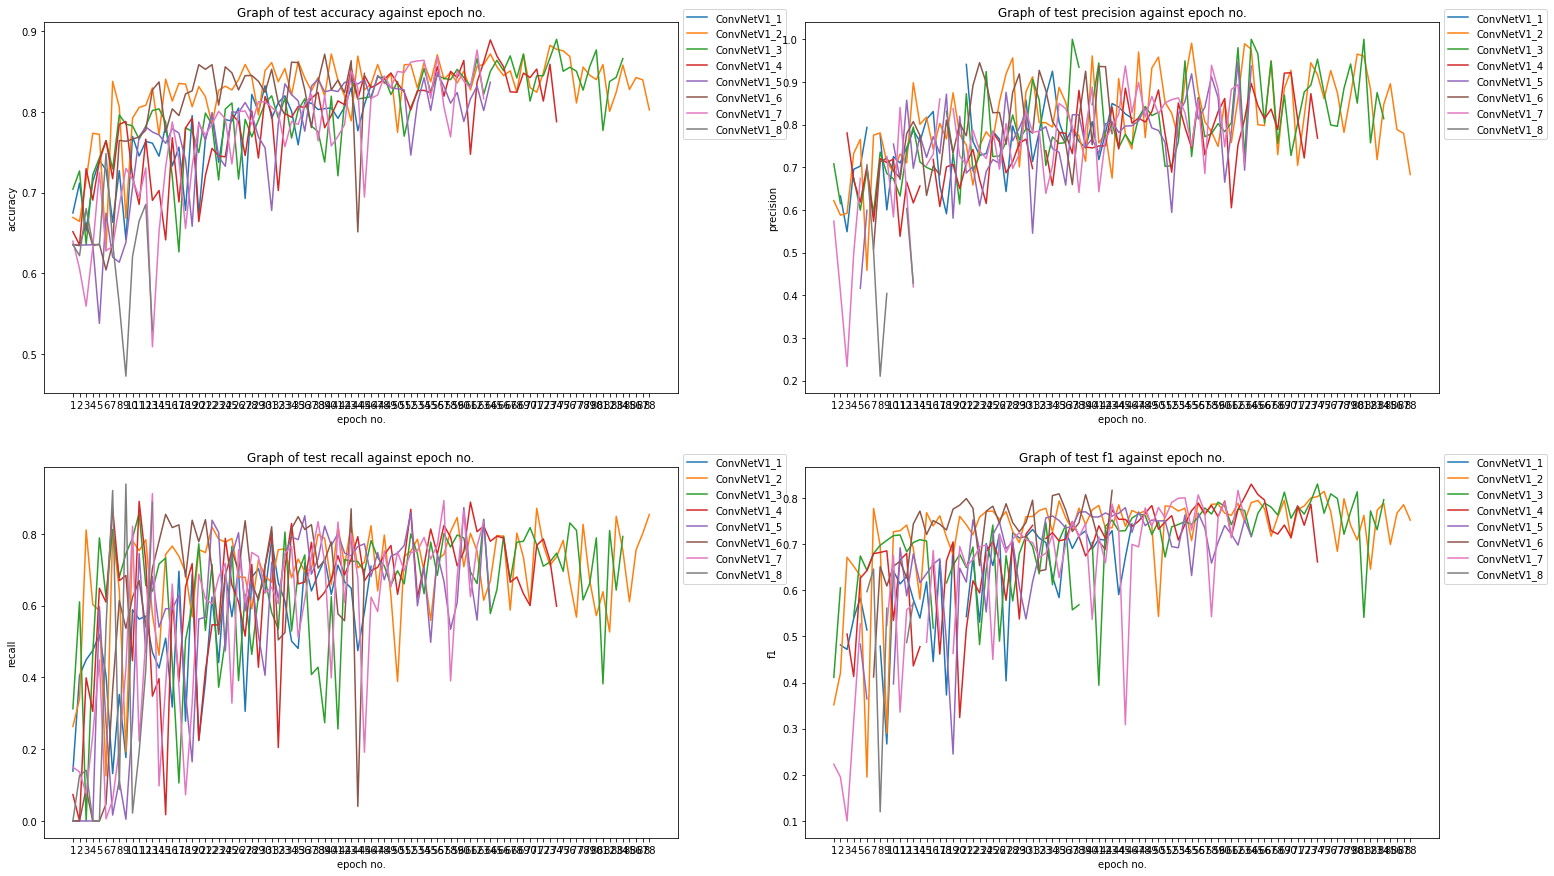

In [143]:
# plot graph of metrics against epochs for all models

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    max_epochs = 0

    for i in range(8):
        y_vals = stats_store[metric][f"ConvNetV1_{i+1}"]
        metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals, label = f"ConvNetV1_{i+1}")
        max_epochs = max(max_epochs, len(y_vals))

    metrics_ax_store[metric].set_xticks(list(range(1, max_epochs+1)))
    # show a legend on the plot
    metrics_ax_store[metric].legend(bbox_to_anchor=(1, 1.05))
    
plt.savefig('ConvNetV1_covid_metrics.png')
plt.show()

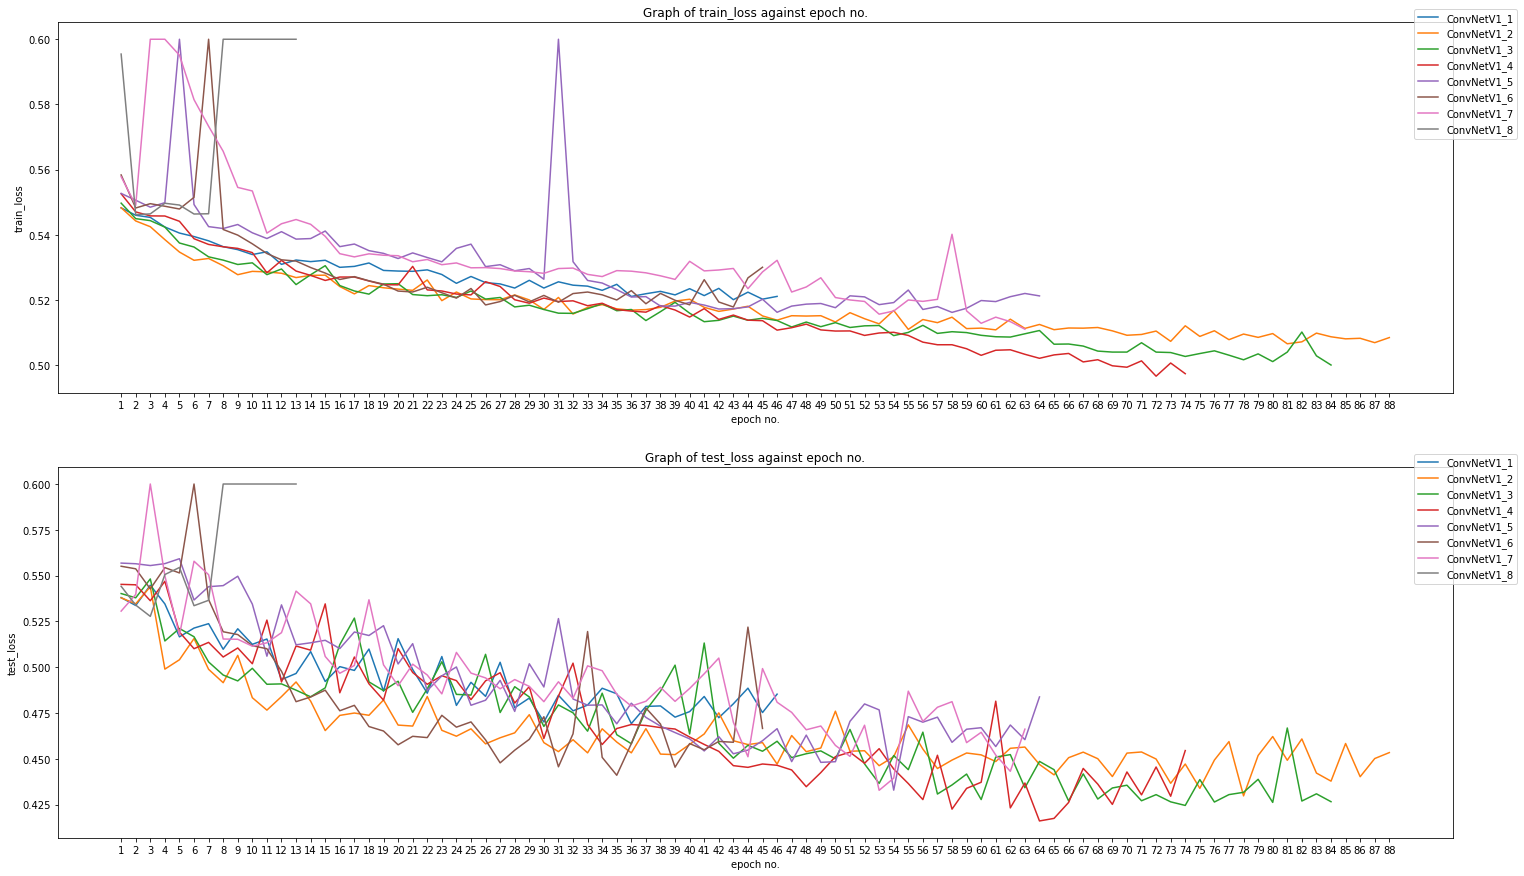

In [146]:
losses = ["train_loss", "test_loss"]

loss_fig, (train_loss_ax, test_loss_ax) = plt.subplots(2, 1, figsize=(25,15))

loss_ax_store = {
    "train_loss": train_loss_ax,
    "test_loss": test_loss_ax,
}

for loss in losses:
    loss_ax_store[loss].title.set_text(f'Graph of {loss} against epoch no.')
    loss_ax_store[loss].set_ylabel(loss)
    loss_ax_store[loss].set_xlabel('epoch no.')

    max_epochs = 0

    for i in range(8):
        y_vals = np.array(stats_store[loss][f"ConvNetV1_{i+1}"])
        y_vals = np.clip(y_vals, a_min=0, a_max=0.6)
        loss_ax_store[loss].plot(list(range(1, len(y_vals)+1)), y_vals, label = f"ConvNetV1_{i+1}")
        max_epochs = max(max_epochs, len(y_vals))

    loss_ax_store[loss].set_xticks(list(range(1, max_epochs+1)))
    # show a legend on the plot
    loss_ax_store[loss].legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV1_covid_losses.png')
plt.show()

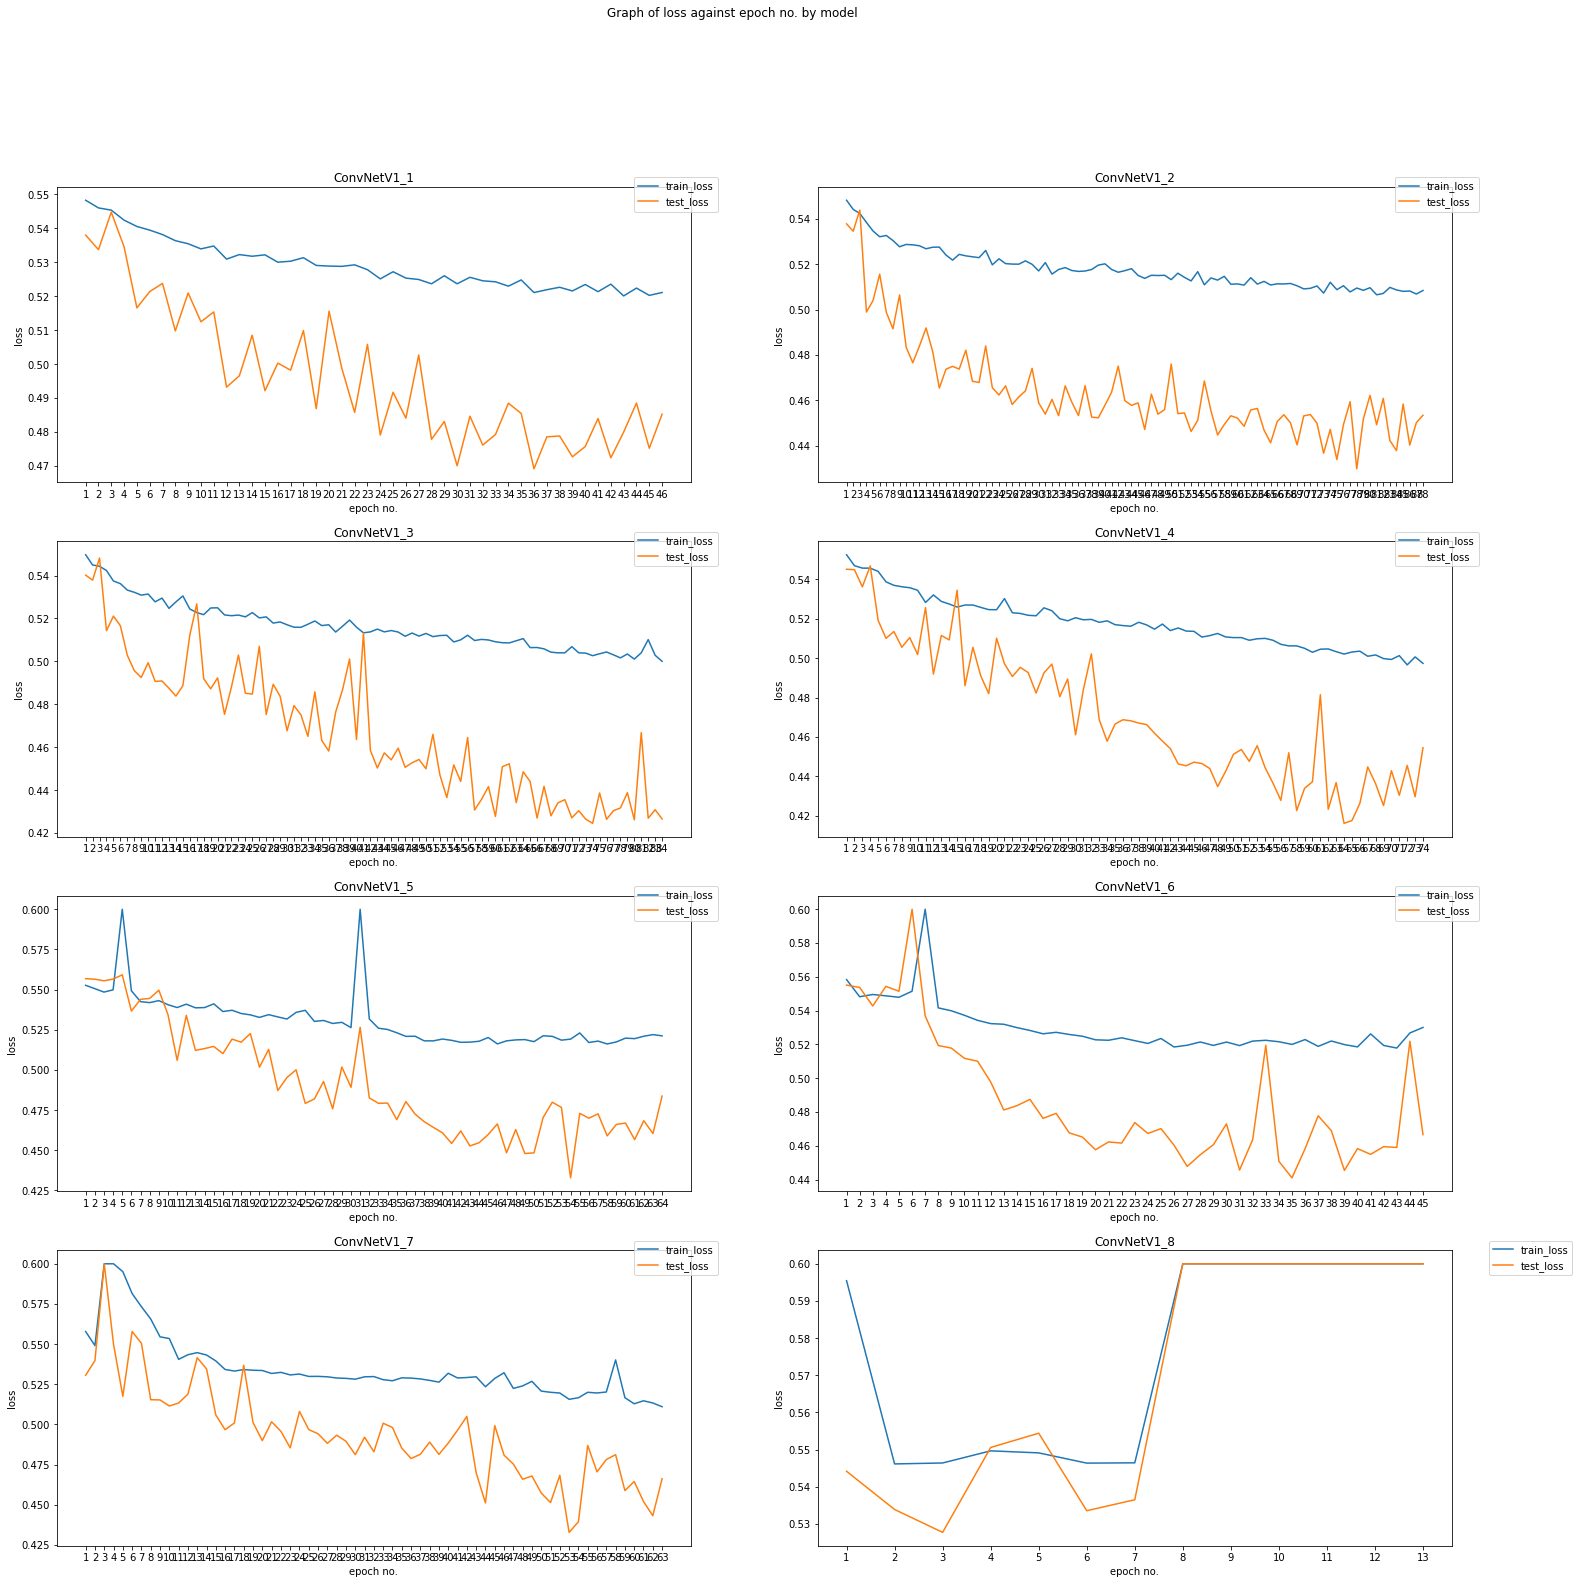

In [147]:
losses = ["train_loss", "test_loss"]

loss_by_net_fig, loss_by_net_axs = plt.subplots(4, 2, figsize=(25, 25))
loss_by_net_fig.suptitle('Graph of loss against epoch no. by model')

for i in range(8):
    loss_by_net_axs[i//2, i%2].title.set_text(f'ConvNetV1_{i+1}')
    loss_by_net_axs[i//2, i%2].set_ylabel('loss')
    loss_by_net_axs[i//2, i%2].set_xlabel('epoch no.')

    max_epochs = 0

    for loss in losses:
        y_vals = np.array(stats_store[loss][f"ConvNetV1_{i+1}"])
        y_vals = np.clip(y_vals, a_min=0, a_max=0.6)
        # y_vals = stats_store[loss][f"ConvNetV1_{i+1}"]
        loss_by_net_axs[i//2, i%2].plot(list(range(1, len(y_vals)+1)), y_vals, label = loss)
        max_epochs = max(max_epochs, len(y_vals))

    loss_by_net_axs[i//2, i%2].set_xticks(list(range(1, max_epochs+1)))
    # show a legend on the plot
    loss_by_net_axs[i//2, i%2].legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV1_covid_losses_by_net.png')
plt.show()

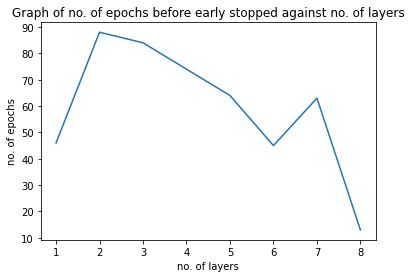

In [148]:
epochs_fig, epochs_ax = plt.subplots()
epochs_ax.title.set_text(f'Graph of no. of epochs before early stopped against no. of layers')
epochs_ax.set_ylabel('no. of epochs')
epochs_ax.set_xlabel('no. of layers')

y_vals = []

for i in range(8):
    epochs = len(stats_store["accuracy"][f"ConvNetV1_{i+1}"])
    y_vals.append(epochs)

epochs_ax.plot(list(range(1, 9)), y_vals)

plt.savefig('ConvNetV1_covid_epoch_layers.png')
plt.show()

### Final Model

Based on research described in the report and the experimental results found above, the classes for the final models are defined.

In [100]:
# definition of standard block with regularization

class ConvNetV2StandardBlock(nn.Module):
    def __init__(self, 
                 input_channels,
                 block_channels):
        super(ConvNetV2StandardBlock, self).__init__()
        
        self.conv = nn.Conv2d(input_channels, block_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(block_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.maxpool(x)
        x = self.relu(x)
        return x

In [101]:
# definition of the a model with the optimal number of convolution layers found (8) and regularization

class ConvNetV2Infected(nn.Module):
    def __init__(self):
        super(ConvNetV2Infected, self).__init__()
        block_sizes = [64, 128, 256, 512]

        self.conv0 = nn.Conv2d(1, 64, 7, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ConvNetV2StandardBlock(64, block_sizes[0])
        self.layer2 = ConvNetV2StandardBlock(block_sizes[0], block_sizes[0])
        self.layer3 = ConvNetV2StandardBlock(block_sizes[0], block_sizes[1])
        self.layer4 = ConvNetV2StandardBlock(block_sizes[1], block_sizes[1])
        self.layer5 = ConvNetV2StandardBlock(block_sizes[1], block_sizes[2])
        self.layer6 = ConvNetV2StandardBlock(block_sizes[2], block_sizes[2])
        self.layer7 = ConvNetV2StandardBlock(block_sizes[2], block_sizes[3])
        self.layer8 = ConvNetV2StandardBlock(block_sizes[3], block_sizes[3])

        self.dropout = nn.Dropout2d()
        self.fc = nn.Linear(block_sizes[3], 2)
        print(self)

    def forward(self, x):
        x = self.conv0(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [158]:
# args for train function
epochs = 1000 # arbitrarily large no. of epochs to ensure model overfits and is stopped by early stopper
weight = torch.tensor([1, 1/3]) # weight to take into account class imbalance
pos_weight = torch.tensor([1, 1.1]) # used to favour positive classes

train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV2Infected(), normalized_train_loader, normalized_test_loader, epochs, "infected", weight, pos_weight, save_dir="saved_models/ConvNetV2Infected", lr_scheduler=True)

ConvNetV2Infected(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

Store training statistics in a dictionary and save them in a `.json` file in case of future use.

In [159]:
# store training statistics in dictionary

stats_store = {
    "train_loss": train_loss, 
    "test_loss": test_loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}

In [160]:
# save or load training statistics (comment / uncomment accordingly)
import json 

store_file_name = "ConvNetV2_infected_stats_store.json"

# UNCOMMENT TO SAVE STATS
with open(store_file_name, "w") as stat_store_file:
    json.dump(stats_store, stat_store_file)

# # UNCOMMENT TO LOAD STATS
# with open(store_file_name) as stat_store_file:
#     stats_store = json.load(stat_store_file)

After which, graphs are plotted to check the performance of the final model on the dataset.

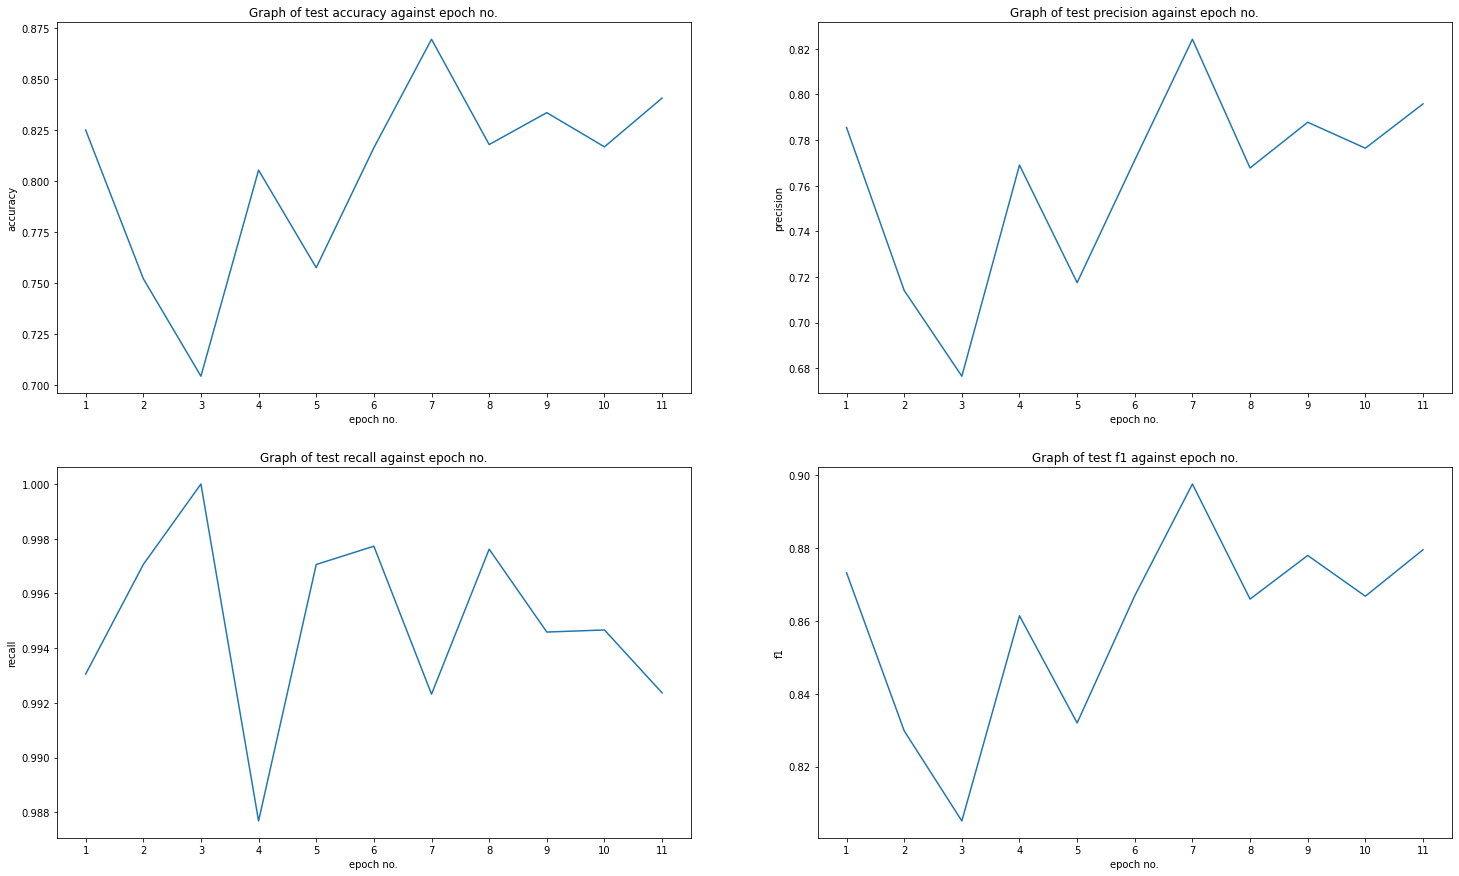

In [161]:
# plot graph of metrics against epochs

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    y_vals = stats_store[metric]
    metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals)

    metrics_ax_store[metric].set_xticks(list(range(1, len(y_vals)+1)))
    
plt.savefig('ConvNetV2_infected_metrics.png')
plt.show()

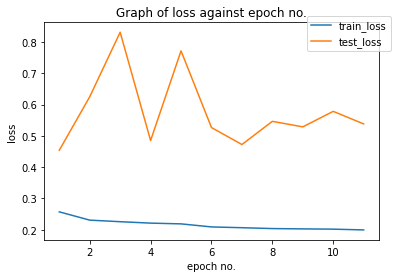

In [162]:
# plot graph of loss against epochs (both train and test loss)

loss_fig, loss_ax = plt.subplots()
loss_ax.title.set_text(f'Graph of loss against epoch no.')
loss_ax.set_ylabel('loss')
loss_ax.set_xlabel('epoch no.')

epochs = len(stats_store["train_loss"])
loss_ax.plot(list(range(1, epochs+1)), stats_store["train_loss"], label="train_loss")
loss_ax.plot(list(range(1, epochs+1)), stats_store["test_loss"], label="test_loss")

loss_ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV2_infected_loss.png')
plt.show()

In [163]:
# separate model definition??
class ConvNetV2Covid(nn.Module):
    def __init__(self):
        super(ConvNetV2Covid, self).__init__()
        block_sizes = [64, 128, 256, 512]

        self.conv0 = nn.Conv2d(1, 64, 7, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ConvNetV2StandardBlock(64, block_sizes[0])
        self.layer2 = ConvNetV2StandardBlock(block_sizes[0], block_sizes[0])
        self.layer3 = ConvNetV2StandardBlock(block_sizes[0], block_sizes[1])
        self.layer4 = ConvNetV2StandardBlock(block_sizes[1], block_sizes[1])

        self.dropout = nn.Dropout2d()
        self.fc = nn.Linear(block_sizes[1], 2)
        print(self)

    def forward(self, x):
        x = self.conv0(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [165]:
epochs = 1000
weight = torch.tensor([1/2, 1])
pos_weight = torch.tensor([1, 1.1])

train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV2Covid(), infected_train_normalized_loader, infected_test_normalized_loader, epochs, "covid", weight, pos_weight, save_dir="saved_models/ConvNetV2Covid", lr_scheduler=True)

ConvNetV2Covid(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [166]:
stats_store = {
    "train_loss": train_loss, 
    "test_loss": test_loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}

In [167]:
import json 

store_file_name = "ConvNetV2_covid_stats_store.json"

# UNCOMMENT TO SAVE STATS
with open(store_file_name, "w") as stat_store_file:
    json.dump(stats_store, stat_store_file)

# # UNCOMMENT TO LOAD STATS
# with open(store_file_name) as stat_store_file:
#     stats_store = json.load(stat_store_file)

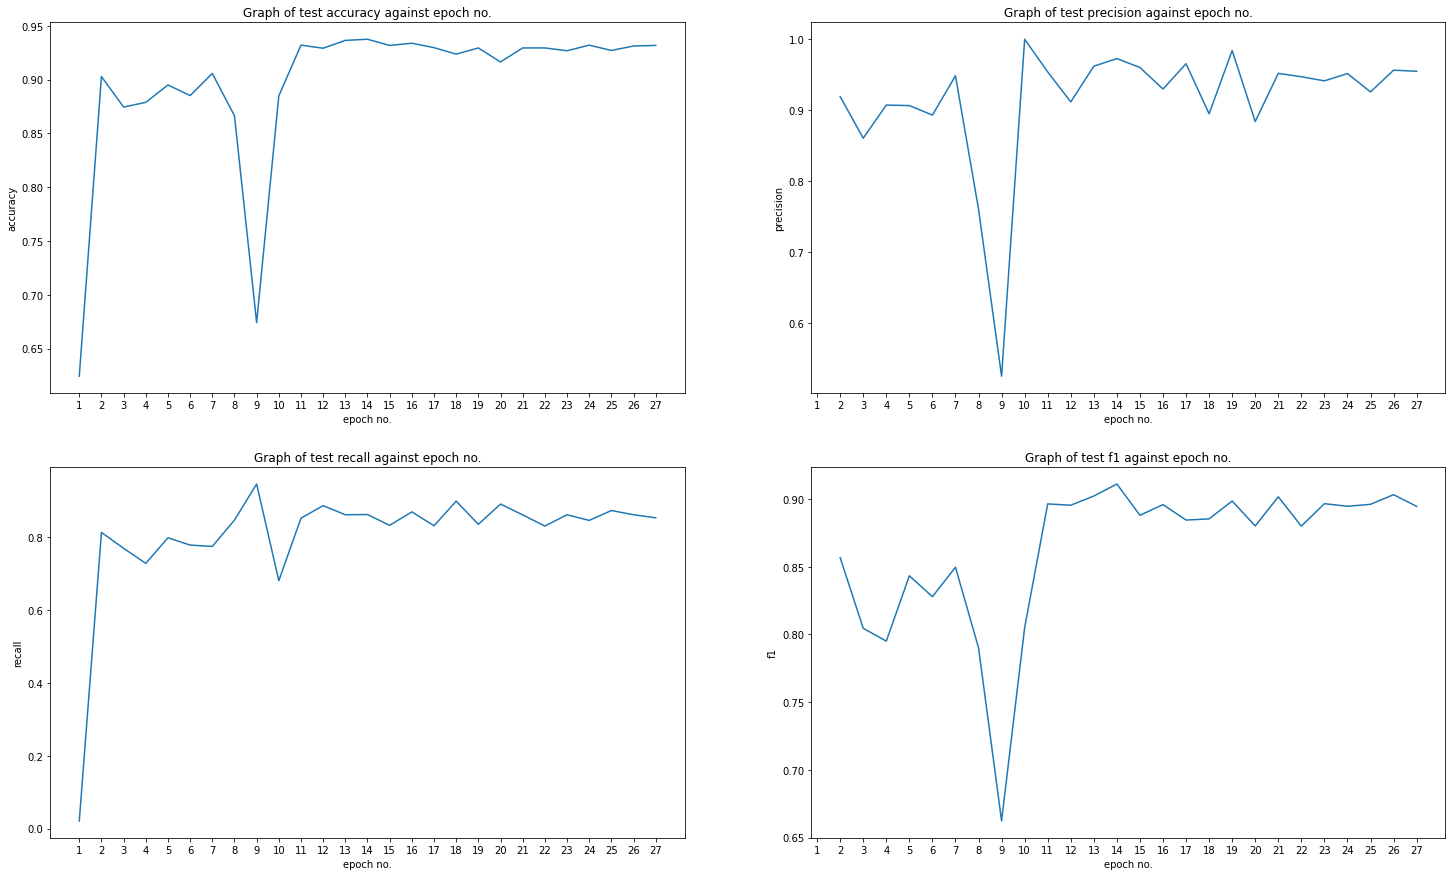

In [168]:
# plot graph of metrics against epochs

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    y_vals = stats_store[metric]
    metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals)

    metrics_ax_store[metric].set_xticks(list(range(1, len(y_vals)+1)))
    
plt.savefig('ConvNetV2_covid_metrics.png')
plt.show()

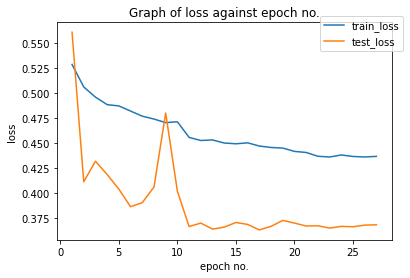

In [169]:
# plot graph of loss against epochs (both train and test loss)

loss_fig, loss_ax = plt.subplots()
loss_ax.title.set_text(f'Graph of loss against epoch no.')
loss_ax.set_ylabel('loss')
loss_ax.set_xlabel('epoch no.')

epochs = len(stats_store["train_loss"])
loss_ax.plot(list(range(1, epochs+1)), stats_store["train_loss"], label="train_loss")
loss_ax.plot(list(range(1, epochs+1)), stats_store["test_loss"], label="test_loss")

loss_ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV2_covid_loss.png')
plt.show()

### Putting It Together

After training the classifiers, best models can be chosen based on the train statistics. These models are then loaded from their respective files.

In [268]:
# load models for their respective classifiers

infected_classifier = load_model(ConvNetV2Infected(), "saved_models/ConvNetV2Infected/7.pt")
covid_classifier = load_model(ConvNetV2Covid(), "saved_models/ConvNetV2Covid/26.pt")

ConvNetV2Infected(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

Next, load and normalize the full validation set based on the train set.

In [269]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 32

# Dataloader from train dataset
train_loader = DataLoader(ld_train, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
train_mean = get_mean(train_loader, num_of_pixels)
train_std = get_standard_deviation(train_loader, num_of_pixels, train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(train_mean, train_std))


The mean of the extended training dataset before normalisation is 0.4702450633049011.
The standard deviation of the extended training dataset before normalisation is 0.244480699300766.


In [270]:
# Instantiating a new validation dataset to be normalized before testing
ld_val_normalized = Lung_Val_Dataset((train_mean, train_std))

# Dataloader from validation test dataset 
normalized_val_loader = DataLoader(ld_val_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
norm_val_mean = get_mean(normalized_val_loader, num_of_pixels)
norm_val_std = get_standard_deviation(normalized_val_loader, num_of_pixels, norm_val_mean)
print("The mean of the validation dataset after normalisation is {}.\nThe standard deviation of the validation dataset after normalisation is {}.".format(norm_val_mean, norm_val_std))


The mean of the validation dataset after normalisation is 0.00027348764706403017.
The standard deviation of the validation dataset after normalisation is 0.051595401018857956.


After which, the images can from the validation set can be labelled by the loaded classifiers.

In [271]:
# make predictions on validation set

all_labels = all_preds = all_images = None

for images, labels in normalized_val_loader:
    if all_labels == None:
        all_labels = labels
    else: 
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    if all_images == None:
        all_images = images
    else: 
        all_images = torch.cat((all_images, images), dim=0)
    
    preds_1 = infected_classifier(images)
    preds_1 = preds_1.argmax(1)
    preds_1 = F.one_hot(preds_1, num_classes=2)
    
    pos_pred = torch.where(preds_1[:, 1]==1, True, False)
    pos_pred = torch.nonzero(pos_pred).squeeze()
    filtered_imgs = torch.index_select(images, 0, pos_pred)

    preds_2 = covid_classifier(filtered_imgs)
    preds_2 = preds_2.argmax(1)
    preds_2 = F.one_hot(preds_2, num_classes=2)

    pred_final = torch.zeros(labels.shape)
    pred_2_ptr = 0

    for i in range(pred_final.shape[0]):
        if preds_1[i][0] == 1:            # predicted as normal
            pred_final[i][0] = 1
            continue
        elif preds_2[pred_2_ptr][1] == 1: # predicted as covid
            pred_final[i][1] = 1
            pred_2_ptr += 1
        else:                             # predicted as infected non-covid
            pred_final[i][2] = 1
            pred_2_ptr += 1
    
    if all_preds == None:
        all_preds = pred_final
    else: 
        all_preds = torch.cat((all_preds, pred_final), dim=0)

In [272]:
# calculate metrics for each class

# get metrics for normal class
norm_true_pos, norm_true_neg, norm_false_pos, norm_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=0)
norm_acc, norm_preci, norm_recall, norm_f1 = get_metrics(norm_true_pos, norm_true_neg, norm_false_pos, norm_false_neg)

print(f"""--- metrics for normal class ---
validation accuracy: {norm_acc}
validation precision: {norm_preci}
validation recall: {norm_recall}
validation f1 score: {norm_f1} """)

# get metrics for infected covid class
covid_true_pos, covid_true_neg, covid_false_pos, covid_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=1)
covid_acc, covid_preci, covid_recall, covid_f1 = get_metrics(covid_true_pos, covid_true_neg, covid_false_pos, covid_false_neg)

print(f"""--- metrics for infected covid class ---
validation accuracy: {covid_acc}
validation precision: {covid_preci}
validation recall: {covid_recall}
validation f1 score: {covid_f1} """)

# get metrics for infected non-covid class
noncovid_true_pos, noncovid_true_neg, noncovid_false_pos, noncovid_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=2)
noncovid_acc, noncovid_preci, noncovid_recall, noncovid_f1 = get_metrics(noncovid_true_pos, noncovid_true_neg, noncovid_false_pos, noncovid_false_neg)

print(f"""--- metrics for infected non-covid class ---
validation accuracy: {noncovid_acc}
validation precision: {noncovid_preci}
validation recall: {noncovid_recall}
validation f1 score: {noncovid_f1} """)

--- metrics for normal class ---
validation accuracy: 0.8399999737739563
validation precision: 1.0
validation recall: 0.5
validation f1 score: 0.6666666666666666 
--- metrics for infected covid class ---
validation accuracy: 0.5600000023841858
validation precision: 0.4375
validation recall: 0.7777777910232544
validation f1 score: 0.5600000034332275 
--- metrics for infected non-covid class ---
validation accuracy: 0.5600000023841858
validation precision: 0.20000000298023224
validation recall: 0.125
validation f1 score: 0.15384615472787935 


Display the predictions and their labels.

In [273]:
# variable to map index to class
class_map = ["normal", "infected_covid", "infected_noncovid"]

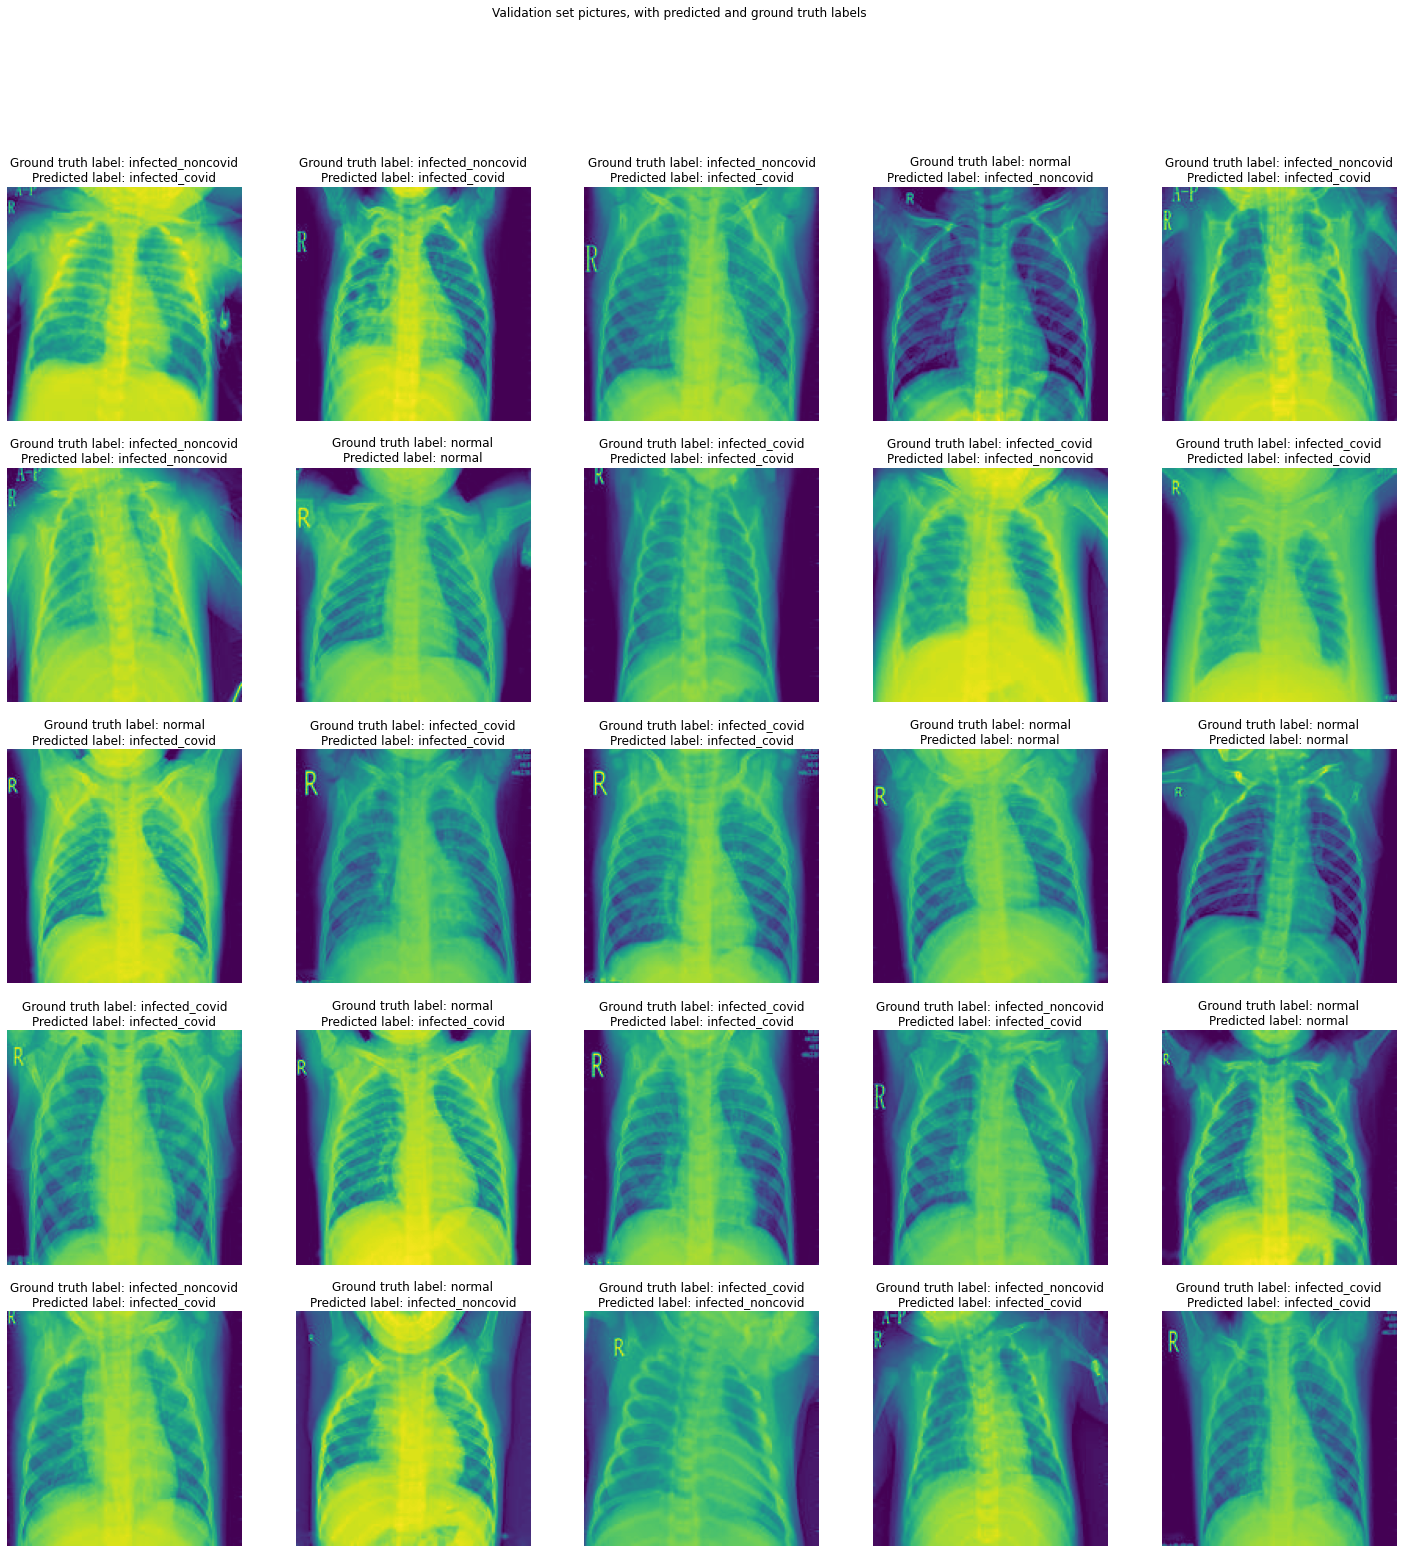

In [274]:
# display validation set images and their labels

rows, cols = 5, 5

val_pred_fig, val_pred_axs = plt.subplots(rows, cols, figsize=(25, 25))
val_pred_fig.suptitle('Validation set pictures, with predicted and ground truth labels')

for i, img in enumerate(all_images):
    gnd_truth_label = class_map[all_labels[i].argmax()]
    pred_label = class_map[all_preds[i].argmax()]
    val_pred_axs[i//cols, i%cols].title.set_text(f'Ground truth label: {gnd_truth_label}\nPredicted label: {pred_label}')

    val_pred_axs[i//cols, i%cols].imshow(img[0].squeeze())
    val_pred_axs[i//cols, i%cols].axis('off')

plt.savefig('validation_set_predictions.png')
plt.show()

## Testing Effectiveness of Data Augmentation

Initialise original dataset (without augmentation).

In [ ]:
class Lung_Train_Dataset_OG(Dataset):
    
    def __init__(self, normalize = None, class_type = 'original'):
        """
        Constructor for the Training Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Three classes will be considered here (normal, infected_covid, and infected_noncovid)
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_noncovid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the original dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_noncovid': 2530}
        
        # Path to images for different parts of the original dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_covid': './dataset/train/infected/covid/',\
                              'train_infected_noncovid': './dataset/train/infected/non-covid/'}

        self.normalize = normalize  

        self.class_type = class_type                                      


    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset (before augmentation_) of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)

    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_covid', or 'infected_noncovid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            im = np.asarray(Image.open(f))/255
        f.close()
        return im

    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal', 'infected_covid' or 'infected_noncovid'.
        - index_val should be an integer with values between 0 and the maximal number of images in the original dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

           
    def __len__(self):
        """
        Length special method.
        
        Depending on the specified class_type, returns the number of images in the training dataset (before augmentation) or
        the number of images in the training/infected/ dataset (before augmentation).
        """
        # Length function
        if self.class_type == 'original':
            return sum(self.dataset_numbers.values())
        elif self.class_type == 'infected':
            return self.dataset_numbers['train_infected_covid']+ self.dataset_numbers['train_infected_noncovid']
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
         Convention:
        - open the image in ./dataset/train/infected/covid/XXX.jpg if XXX is strictly lower than 1345 (number of images in the ./dataset/train/infected/covid/ folder)
        - open the image in ./dataset/train/infected/non-covid/YYY.jpg if XXX is between 1345 (inclusive) and 3875 (exclusive) (total number of images in 
          the ./dataset/train/infected/covid/ and ./dataset/train/infected/non-covid/ folders), where YYY is defined as YYY = XXX - 1345.
        - otherwise, open the image in the ./dataset/train/normal/ folder 

        Returns the image and its label as a one hot vector, both in torch tensor format in dataset.
        """

        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0]) # number of images in class 0: normal = 1341
        second_val = int(list(self.dataset_numbers.values())[1]) # number of images in class 1: infected_covid = 1345
        third_val = int(list(self.dataset_numbers.values())[2]) # number of images in class 2: infected_noncovid = 2530
        if index < second_val: # not inclusive because image labelling starts from 0, not 1
            class_val = 'infected_covid'
            label = torch.Tensor([0, 1, 0])

        elif second_val <= index < (second_val + third_val):
            index -= second_val
            class_val = 'infected_noncovid'
            label = torch.Tensor([0, 0, 1])

        else:
            index -= (second_val + third_val)
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(im).float()
      
        if self.normalize != None:
            mean = self.normalize[0]
            std = self.normalize[1]
            normalization = transforms.Normalize((mean), (std))
            im = normalization(im)
        return im, label

Load and normalise dataset based on unaugmented dataset.

In [235]:
# load non-augmented dataset from file
no_aug_ld_train = Lung_Train_Dataset_OG() # non-augmented dataset
no_aug_ld_train.describe()
print(len(no_aug_ld_train)) # gives total number of images in the extended train dataset

This is the training dataset (before augmentation_) of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.

5216


In [242]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 32

# Dataloader from train dataset
no_aug_train_loader = DataLoader(no_aug_ld_train, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(no_aug_ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
no_aug_train_mean = get_mean(no_aug_train_loader, num_of_pixels)
no_aug_train_std = get_standard_deviation(no_aug_train_loader, num_of_pixels, no_aug_train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(no_aug_train_mean, no_aug_train_std))


The mean of the extended training dataset before normalisation is 0.4824070930480957.
The standard deviation of the extended training dataset before normalisation is 0.23631201684474945.


In [243]:
# Instantiating a new training dataset to be normalized before training
no_aug_ld_train_normalized = Lung_Train_Dataset_OG((no_aug_train_mean, no_aug_train_std))

# Dataloader from normalized train dataset 
no_aug_normalized_train_loader = DataLoader(no_aug_ld_train_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
no_aug_norm_train_mean = get_mean(no_aug_normalized_train_loader, num_of_pixels)
no_aug_norm_train_std = get_standard_deviation(no_aug_normalized_train_loader, num_of_pixels, no_aug_norm_train_mean)
print("The mean of the extended training dataset after normalisation is {}.\nThe standard deviation of the extended training dataset after normalisation is {}.".format(no_aug_norm_train_mean, no_aug_norm_train_std))


The mean of the extended training dataset after normalisation is -4.949547474097926e-07.
The standard deviation of the extended training dataset after normalisation is 1.0.


In [244]:
# Instantiating a new test dataset to be normalized before testing
no_aug_ld_test_normalized = Lung_Test_Dataset((no_aug_train_mean, no_aug_train_std))

# Dataloader from normalized test dataset 
no_aug_normalized_test_loader = DataLoader(no_aug_ld_test_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
no_aug_norm_test_mean = get_mean(no_aug_normalized_test_loader, num_of_pixels)
no_aug_norm_test_std = get_standard_deviation(no_aug_normalized_test_loader, num_of_pixels, no_aug_norm_test_mean)
print("The mean of the test dataset after normalisation is {}.\nThe standard deviation of the test dataset after normalisation is {}.".format(no_aug_norm_test_mean, no_aug_norm_test_std))


The mean of the test dataset after normalisation is -0.004077740013599396.
The standard deviation of the test dataset after normalisation is 0.34268224239349365.


Train infected classifier.

In [246]:
# args for train function
epochs = 1000 # arbitrarily large no. of epochs to ensure model overfits and is stopped by early stopper
weight = torch.tensor([1, 1/3]) # weight to take into account class imbalance
pos_weight = torch.tensor([1, 1.1]) # used to favour positive classes

train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV2Infected(), no_aug_normalized_train_loader, no_aug_normalized_test_loader, epochs, "infected", weight, pos_weight, save_dir="saved_models/ConvNetV2Infected_NoAug", lr_scheduler=True)

ConvNetV2Infected(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

Save infected classifier stats.

In [247]:
stats_store = {
    "train_loss": train_loss, 
    "test_loss": test_loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}

In [248]:
import json 

store_file_name = "ConvNetV2_infected_noaug_stats_store.json"

# UNCOMMENT TO SAVE STATS
with open(store_file_name, "w") as stat_store_file:
    json.dump(stats_store, stat_store_file)

# # UNCOMMENT TO LOAD STATS
# with open(store_file_name) as stat_store_file:
#     stats_store = json.load(stat_store_file)

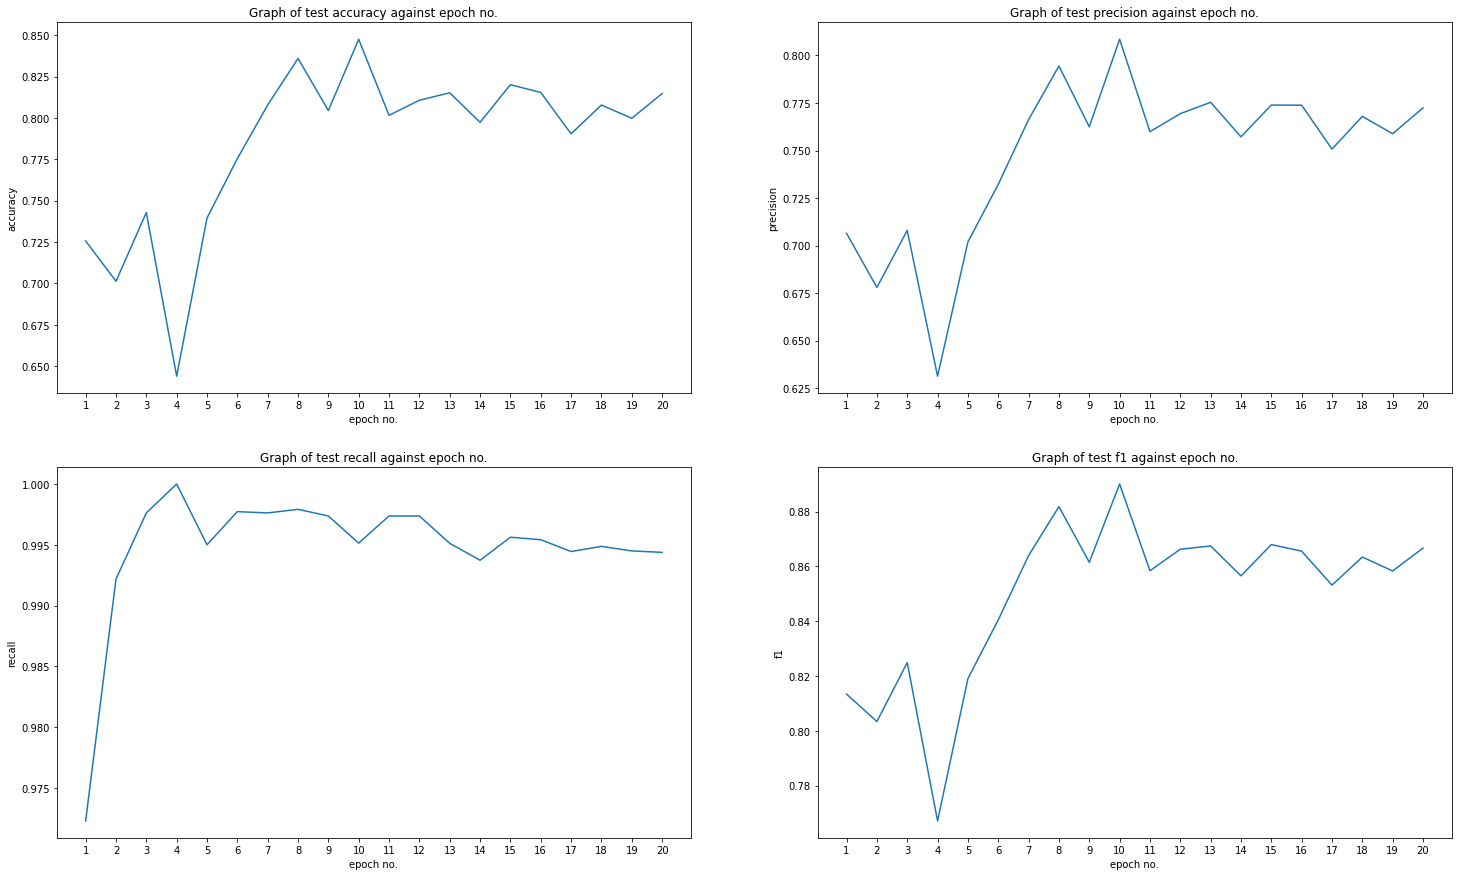

In [249]:
# plot graph of metrics against epochs

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    y_vals = stats_store[metric]
    metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals)

    metrics_ax_store[metric].set_xticks(list(range(1, len(y_vals)+1)))
    
plt.savefig('ConvNetV2_infected_noaug_metrics.png')
plt.show()

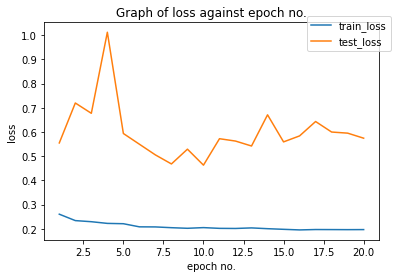

In [250]:
# plot graph of loss against epochs (both train and test loss)

loss_fig, loss_ax = plt.subplots()
loss_ax.title.set_text(f'Graph of loss against epoch no.')
loss_ax.set_ylabel('loss')
loss_ax.set_xlabel('epoch no.')

epochs = len(stats_store["train_loss"])
loss_ax.plot(list(range(1, epochs+1)), stats_store["train_loss"], label="train_loss")
loss_ax.plot(list(range(1, epochs+1)), stats_store["test_loss"], label="test_loss")

loss_ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV2_infected_noaug_loss.png')
plt.show()

Load and normalise dataset based on unaugmented infected dataset.

In [251]:
no_aug_infected_ld_train = Lung_Train_Dataset_OG(class_type="infected") # non-augmented dataset
no_aug_infected_ld_train.describe()
print(len(no_aug_infected_ld_train)) # gives total number of images in the extended train dataset

This is the training dataset (before augmentation_) of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_noncovid, in folder ./dataset/train/infected/non-covid/: 2530 images.

3875


In [253]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 32

# Dataloader from train dataset
no_aug_infected_train_loader = DataLoader(no_aug_infected_ld_train, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(no_aug_infected_ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
no_aug_infected_train_mean = get_mean(no_aug_infected_train_loader, num_of_pixels)
no_aug_infected_train_std = get_standard_deviation(no_aug_infected_train_loader, num_of_pixels, no_aug_infected_train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(no_aug_infected_train_mean, no_aug_infected_train_std))


The mean of the extended training dataset before normalisation is 0.48321425914764404.
The standard deviation of the extended training dataset before normalisation is 0.23297840356826782.


In [254]:
# Instantiating a new training dataset to be normalized before training
no_aug_infected_ld_train_normalized = Lung_Train_Dataset_OG((no_aug_infected_train_mean, no_aug_infected_train_std), class_type="infected")

# Dataloader from normalized train dataset 
no_aug_infected_normalized_train_loader = DataLoader(no_aug_infected_ld_train_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
no_aug_infected_norm_train_mean = get_mean(no_aug_infected_normalized_train_loader, num_of_pixels)
no_aug_infected_norm_train_std = get_standard_deviation(no_aug_infected_normalized_train_loader, num_of_pixels, no_aug_infected_norm_train_mean)
print("The mean of the extended training dataset after normalisation is {}.\nThe standard deviation of the extended training dataset after normalisation is {}.".format(no_aug_infected_norm_train_mean, no_aug_infected_norm_train_std))


The mean of the extended training dataset after normalisation is 1.0674282435729765e-07.
The standard deviation of the extended training dataset after normalisation is 1.0000001192092896.


In [255]:
# Instantiating a new test dataset to be normalized before testing
no_aug_infected_ld_test_normalized = Lung_Test_Dataset((no_aug_infected_train_mean, no_aug_infected_train_std), class_type="infected")

# Dataloader from normalized test dataset 
no_aug_infected_normalized_test_loader = DataLoader(no_aug_infected_ld_test_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
no_aug_infected_norm_test_mean = get_mean(no_aug_infected_normalized_test_loader, num_of_pixels)
no_aug_infected_norm_test_std = get_standard_deviation(no_aug_infected_normalized_test_loader, num_of_pixels, no_aug_infected_norm_test_mean)
print("The mean of the test dataset after normalisation is {}.\nThe standard deviation of the test dataset after normalisation is {}.".format(no_aug_infected_norm_test_mean, no_aug_infected_norm_test_std))


The mean of the test dataset after normalisation is -0.007024485617876053.
The standard deviation of the test dataset after normalisation is 0.31021684408187866.


Train covid classifier.

In [256]:
epochs = 1000
weight = torch.tensor([1/2, 1])
pos_weight = torch.tensor([1, 1.1])

train_loss, test_loss, accuracy, precision, recall, f1 = train(ConvNetV2Covid(), no_aug_infected_normalized_train_loader, no_aug_infected_normalized_test_loader, epochs, "covid", weight, pos_weight, save_dir="saved_models/ConvNetV2Covid_NoAug", lr_scheduler=True)

ConvNetV2Covid(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

Save and display graphs for covid classifier.

In [257]:
stats_store = {
    "train_loss": train_loss, 
    "test_loss": test_loss,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
}

In [258]:
import json 

store_file_name = "ConvNetV2_covid_noaug_stats_store.json"

# UNCOMMENT TO SAVE STATS
with open(store_file_name, "w") as stat_store_file:
    json.dump(stats_store, stat_store_file)

# # UNCOMMENT TO LOAD STATS
# with open(store_file_name) as stat_store_file:
#     stats_store = json.load(stat_store_file)

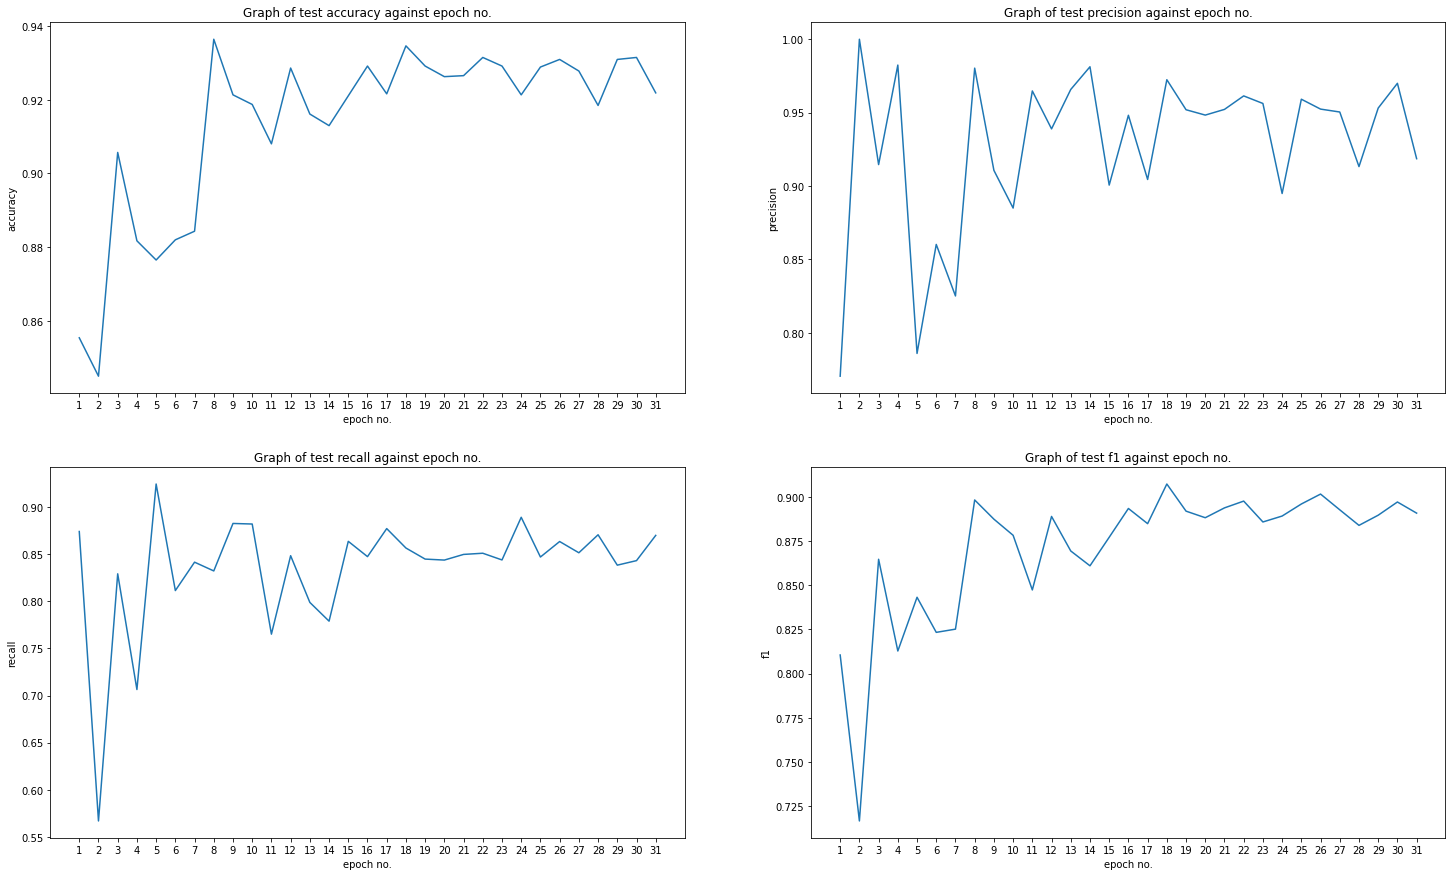

In [259]:
# plot graph of metrics against epochs

metrics = ["accuracy", "precision", "recall", "f1"]

metrics_fig, ((accuracy_ax, precision_ax), (recall_ax, f1_ax)) = plt.subplots(2, 2, figsize=(25,15))

metrics_ax_store = {
    "accuracy": accuracy_ax,
    "precision": precision_ax,
    "recall": recall_ax,
    "f1": f1_ax,
}

for metric in metrics:
    metrics_ax_store[metric].title.set_text(f'Graph of test {metric} against epoch no.')
    metrics_ax_store[metric].set_ylabel(metric)
    metrics_ax_store[metric].set_xlabel('epoch no.')

    y_vals = stats_store[metric]
    metrics_ax_store[metric].plot(list(range(1, len(y_vals)+1)), y_vals)

    metrics_ax_store[metric].set_xticks(list(range(1, len(y_vals)+1)))
    
plt.savefig('ConvNetV2_covid_noaug_metrics.png')
plt.show()

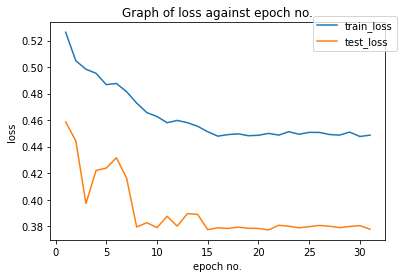

In [260]:
# plot graph of loss against epochs (both train and test loss)

loss_fig, loss_ax = plt.subplots()
loss_ax.title.set_text(f'Graph of loss against epoch no.')
loss_ax.set_ylabel('loss')
loss_ax.set_xlabel('epoch no.')

epochs = len(stats_store["train_loss"])
loss_ax.plot(list(range(1, epochs+1)), stats_store["train_loss"], label="train_loss")
loss_ax.plot(list(range(1, epochs+1)), stats_store["test_loss"], label="test_loss")

loss_ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.savefig('ConvNetV2_covid_noaug_loss.png')
plt.show()

Load best models based on graphs.

In [261]:
# load models for their respective classifiers

infected_classifier = load_model(ConvNetV2Infected(), "saved_models/ConvNetV2Infected_NoAug/10.pt")
covid_classifier = load_model(ConvNetV2Covid(), "saved_models/ConvNetV2Covid_NoAug/18.pt")

ConvNetV2Infected(
  (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ConvNetV2StandardBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

Next, load and normalize the full validation set based on the train set.

In [262]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 32

# Dataloader from train dataset
train_loader = DataLoader(no_aug_ld_train, batch_size = bs_val, num_workers = 0, shuffle = True)

num_of_pixels = len(no_aug_ld_train) * 150 * 150  # total number of pixels = number of images * image width * image height
train_mean = get_mean(train_loader, num_of_pixels)
train_std = get_standard_deviation(train_loader, num_of_pixels, train_mean)

print("The mean of the extended training dataset before normalisation is {}.\nThe standard deviation of the extended training dataset before normalisation is {}.".format(train_mean, train_std))


The mean of the extended training dataset before normalisation is 0.4824070930480957.
The standard deviation of the extended training dataset before normalisation is 0.23631198704242706.


In [263]:
# Instantiating a new validation dataset to be normalized before testing
ld_val_normalized = Lung_Val_Dataset((train_mean, train_std))

# Dataloader from validation test dataset 
normalized_val_loader = DataLoader(ld_val_normalized, batch_size = bs_val, num_workers = 0, shuffle = True)
norm_val_mean = get_mean(normalized_val_loader, num_of_pixels)
norm_val_std = get_standard_deviation(normalized_val_loader, num_of_pixels, norm_val_mean)
print("The mean of the validation dataset after normalisation is {}.\nThe standard deviation of the validation dataset after normalisation is {}.".format(norm_val_mean, norm_val_std))


The mean of the validation dataset after normalisation is 0.00031920921173878014.
The standard deviation of the validation dataset after normalisation is 0.07518765330314636.


After which, the images can from the validation set can be labelled by the loaded classifiers.

In [264]:
# make predictions on validation set

all_labels = all_preds = all_images = None

for images, labels in normalized_val_loader:
    if all_labels == None:
        all_labels = labels
    else: 
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    if all_images == None:
        all_images = images
    else: 
        all_images = torch.cat((all_images, images), dim=0)
    
    preds_1 = infected_classifier(images)
    preds_1 = preds_1.argmax(1)
    preds_1 = F.one_hot(preds_1, num_classes=2)
    
    pos_pred = torch.where(preds_1[:, 1]==1, True, False)
    pos_pred = torch.nonzero(pos_pred).squeeze()
    filtered_imgs = torch.index_select(images, 0, pos_pred)

    preds_2 = covid_classifier(filtered_imgs)
    preds_2 = preds_2.argmax(1)
    preds_2 = F.one_hot(preds_2, num_classes=2)

    pred_final = torch.zeros(labels.shape)
    pred_2_ptr = 0

    for i in range(pred_final.shape[0]):
        if preds_1[i][0] == 1:            # predicted as normal
            pred_final[i][0] = 1
            continue
        elif preds_2[pred_2_ptr][1] == 1: # predicted as covid
            pred_final[i][1] = 1
            pred_2_ptr += 1
        else:                             # predicted as infected non-covid
            pred_final[i][2] = 1
            pred_2_ptr += 1
    
    if all_preds == None:
        all_preds = pred_final
    else: 
        all_preds = torch.cat((all_preds, pred_final), dim=0)

In [265]:
# calculate metrics for each class

# get metrics for normal class
norm_true_pos, norm_true_neg, norm_false_pos, norm_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=0)
norm_acc, norm_preci, norm_recall, norm_f1 = get_metrics(norm_true_pos, norm_true_neg, norm_false_pos, norm_false_neg)

print(f"""--- metrics for normal class ---
validation accuracy: {norm_acc}
validation precision: {norm_preci}
validation recall: {norm_recall}
validation f1 score: {norm_f1} """)

# get metrics for infected covid class
covid_true_pos, covid_true_neg, covid_false_pos, covid_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=1)
covid_acc, covid_preci, covid_recall, covid_f1 = get_metrics(covid_true_pos, covid_true_neg, covid_false_pos, covid_false_neg)

print(f"""--- metrics for infected covid class ---
validation accuracy: {covid_acc}
validation precision: {covid_preci}
validation recall: {covid_recall}
validation f1 score: {covid_f1} """)

# get metrics for infected non-covid class
noncovid_true_pos, noncovid_true_neg, noncovid_false_pos, noncovid_false_neg = get_confusion_matrix(all_labels, all_preds, class_idx=2)
noncovid_acc, noncovid_preci, noncovid_recall, noncovid_f1 = get_metrics(noncovid_true_pos, noncovid_true_neg, noncovid_false_pos, noncovid_false_neg)

print(f"""--- metrics for infected non-covid class ---
validation accuracy: {noncovid_acc}
validation precision: {noncovid_preci}
validation recall: {noncovid_recall}
validation f1 score: {noncovid_f1} """)

--- metrics for normal class ---
validation accuracy: 1.0
validation precision: 1.0
validation recall: 1.0
validation f1 score: 1.0 
--- metrics for infected covid class ---
validation accuracy: 0.6800000071525574
validation precision: 0.5384615659713745
validation recall: 0.7777777910232544
validation f1 score: 0.6363636600084539 
--- metrics for infected non-covid class ---
validation accuracy: 0.6800000071525574
validation precision: 0.5
validation recall: 0.25
validation f1 score: 0.3333333333333333 


Display the predictions and their labels.

In [266]:
# variable to map index to class
class_map = ["normal", "infected_covid", "infected_noncovid"]

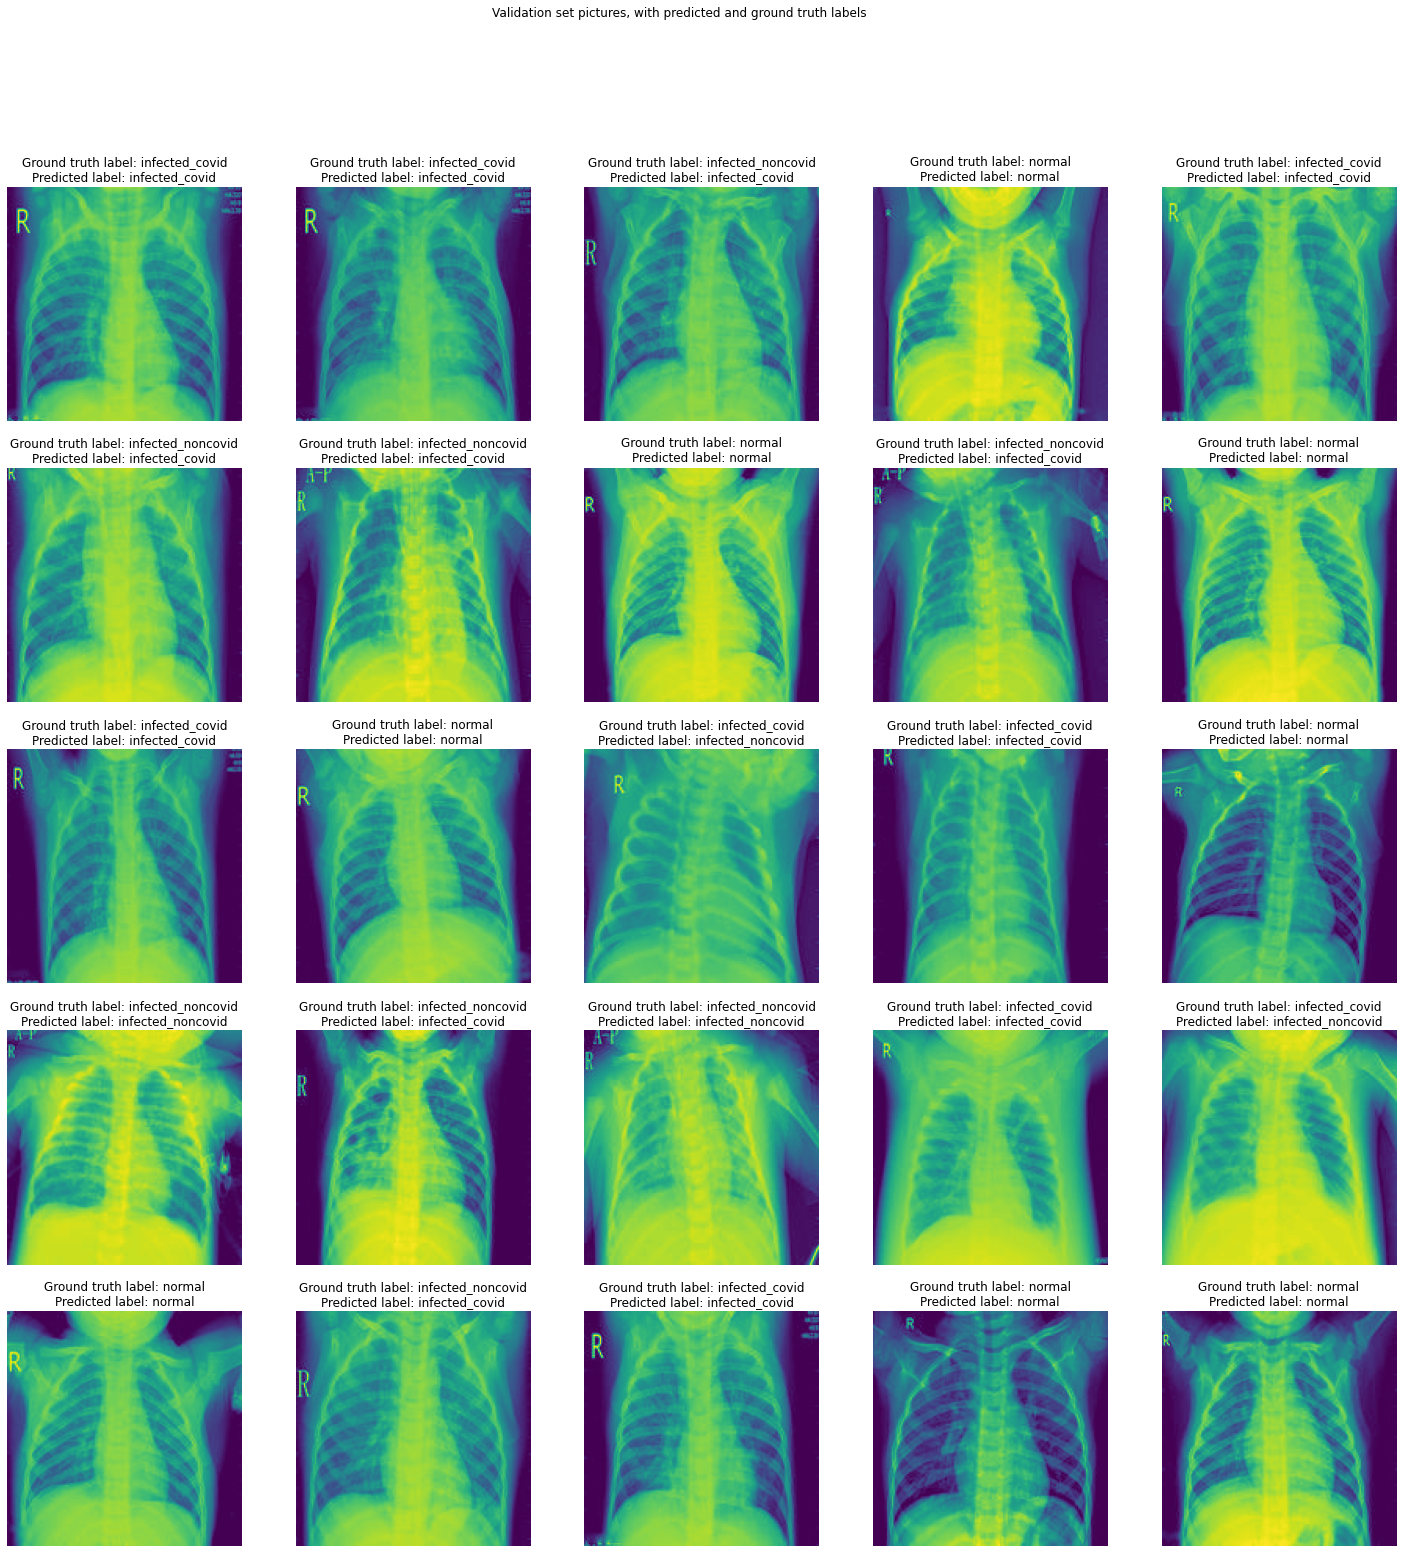

In [267]:
# display validation set images and their labels

rows, cols = 5, 5

val_pred_fig, val_pred_axs = plt.subplots(rows, cols, figsize=(25, 25))
val_pred_fig.suptitle('Validation set pictures, with predicted and ground truth labels')

for i, img in enumerate(all_images):
    gnd_truth_label = class_map[all_labels[i].argmax()]
    pred_label = class_map[all_preds[i].argmax()]
    val_pred_axs[i//cols, i%cols].title.set_text(f'Ground truth label: {gnd_truth_label}\nPredicted label: {pred_label}')

    val_pred_axs[i//cols, i%cols].imshow(img[0].squeeze())
    val_pred_axs[i//cols, i%cols].axis('off')

plt.savefig('validation_set_predictions.png')
plt.show()